# TL;DR

The goal of this notebook is to visualize COVID-19 infections using data from https://github.com/CSSEGISandData/COVID-19.

Most illustrative plots of how the pandemic is being controlled:
- [Relative increases per day by country](#country_relative_increases)
- [Relative increases per day by state](#us_state_relative_increases)

Visualizations found in this notebook:
- Countries
    - [Top 20 countries by cumulative confirmed COVID-19 cases](#top_countries_confirmed)
    - [Top 10 countries by NEW confirmed COVID-19 cases](#top_countries_confirmed_new)
    - [Time-series plots of infections in most infected countries](#time-series_countries)
    - [Forecasts of infections/deaths 1 and 7 days in the future](#forecasts_countries)
    - [Relative increases per day by country](#country_relative_increases)
    - [Time-series plots of mortality](#time-series_country_mortality)
    - [Mortality as currently measured, compared to expected based on WHO mortality expectations](#counry_mortality_expectations)
      - [Source of expectations](http://weekly.chinacdc.cn/en/article/id/e53946e2-c6c4-41e9-9a9b-fea8db1a8f51)
    - [Density of infections per million people](#density_of_infections_by_country)
    - [How many days behind is each country from Italy?](#days_behind)
- US states
    - [US states with the most new infections](#states_most_infections)
    - [Time-series plots of infections in most-infected states](#time-series_states)
    - [State forecasts of infections/deaths 1 and 7 days in the future](#forecast_us_state)
    - [States and their daily increase fraction in confirmed cases/deaths](#us_state_daily_increase_fraction)
    - [Compare US state infections against Washington](#state_infections_vs_wa)
    - [Compare US state infections against New York](#state_infections_vs_ny)
    - [Mortality rate by US state](#mortality_by_us_state)
    - [Relative increases per day by state](#us_state_relative_increases)
    - [When will each US state hit 1 case?](#us_state_0_new)
    - [Smoothed trend for each US state](#us_state_smoothed_trend)
    - [Maps of per-capita new confirmed/deaths](#us_state_maps)

In [114]:


from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



# Imports and definitions

In [1]:
import pandas as pd
import numpy as np
import os
import datetime
import re
from dateutil import parser
from matplotlib import pyplot as plt
import warnings

plt.rcParams['figure.figsize'] = 12,6
#plt.style.use('seaborn-dark-palette')
#plt.style.available
plt.style.use('seaborn-darkgrid')
pd.options.display.max_columns = 300

def datetime_to_unixtime(dt):
    return (dt - datetime.datetime(1970, 1, 1)).total_seconds()

# Load data

In [115]:
# define paths to each raw file
d_ts = {}
#d_ts['confirmed'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
#d_ts['deaths'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
d_ts['confirmed'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
d_ts['deaths'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

#d_ts['recovered'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'

# load in each CSV
d_data = {}
for key, file_path in d_ts.items():
    d_data[key] = pd.read_csv(file_path)

# Clean to long form

In [116]:
def clean_wide_to_long(dfp, key):
    # find columns with dates in them
    cols = list(dfp.columns)
    date_cols = [col for col in cols if re.findall('(\d+/\d+/\d+)', col)]  #if '/' in col
    non_date_cols = list(set(cols) - set(date_cols))
    
    # wide to long
    dfp_melt = pd.melt(dfp, id_vars=non_date_cols, value_vars=date_cols)
    dfp_melt = dfp_melt.rename(columns={'variable': 'date', 
                                        'value': key,
                                        'Country/Region': 'country',
                                        'Province/State': 'state',
                                       })
    dfp_melt['date'] = dfp_melt['date'].apply(parser.parse)
    dfp_melt[key] = dfp_melt[key].apply(float)
    return dfp_melt

In [117]:
# convert from wide to long form
d_dfps = {}
dfp = None
merge_cols = ['country', 'state', 'date']
for key, dfp_wide in d_data.items():
    print(f'metric: {key} at {datetime.datetime.now()}')
    d_dfps[key] = clean_wide_to_long(dfp_wide, key)
    
    if dfp is None:
        dfp = d_dfps[key].copy()
    else:
        dfp_temp = d_dfps[key][merge_cols + [key]]
        dfp = dfp.merge(dfp_temp, on=merge_cols, how='left')

ds_latest = dfp['date'].max().strftime('%Y-%m-%d')
print(f"Latest data from {ds_latest}")

metric: confirmed at 2020-12-23 21:55:50.301214
metric: deaths at 2020-12-23 21:55:54.337608
Latest data from 2020-12-23


In [118]:
# aggregate by country (the US data is reported by state)
dfp_country = (dfp.groupby(['date', 'country'], as_index=False).
               agg({
                   'confirmed': np.sum,
                   'deaths': np.sum,
                   #'recovered': np.sum,
               }))
#dfp_country['active'] = dfp_country['confirmed'] - dfp_country['recovered']
dfp_country['confirmed_lag1'] = dfp_country.groupby(['country'])['confirmed'].shift(1)
dfp_country['confirmed_new'] = dfp_country['confirmed'] - dfp_country['confirmed_lag1']
dfp_country['deaths_lag1'] = dfp_country.groupby(['country'])['deaths'].shift(1)
dfp_country['deaths_new'] = dfp_country['deaths'] - dfp_country['deaths_lag1']
dfp_country['mortality_rate'] = dfp_country['deaths'] / dfp_country['confirmed']

# smoothed trend
window_size = 7
dfp_country['deaths_new_smooth'] = dfp_country.groupby(['country'], as_index=False)['deaths_new'].rolling(window_size).mean().reset_index(0,drop=True)
dfp_country['confirmed_new_smooth'] = dfp_country.groupby(['country'], as_index=False)['confirmed_new'].rolling(window_size).mean().reset_index(0,drop=True)

<a id='top_countries_confirmed'></a>
##### Top 20 countries by cumulative confirmed COVID-19 cases

In [119]:
# get the top countries
id_cols = ['date', 'country']
value_cols = [
    'confirmed',
    'confirmed_new',
    'deaths',
    'deaths_new',
    #'active',
    'mortality_rate',
]
dfp_top_countries = dfp_country[dfp_country['date'] == dfp_country['date'].max()][id_cols + value_cols]
dfp_top_countries = dfp_top_countries.sort_values(by='deaths', ascending=0).reset_index(drop=True)
for key in value_cols:
    if 'rate' in key:
        continue
    dfp_top_countries[key] = dfp_top_countries[key].apply(int)
dfp_top_countries.head(20)

date         country  confirmed  confirmed_new  deaths  deaths_new  \
0  2020-12-23              US   18458373         228131  326124        3359   
1  2020-12-23          Brazil    7365517          46696  189220         961   
2  2020-12-23           India   10123778          24712  146756         312   
3  2020-12-23          Mexico    1350079          11653  120311         816   
4  2020-12-23           Italy    1991278          13908   70395         553   
5  2020-12-23  United Kingdom    2155996          39387   69157         748   
6  2020-12-23          France    2562615          15038   62098         277   
7  2020-12-23            Iran    1177004           6261   54156         153   
8  2020-12-23          Russia    2905196          26814   51810         536   
9  2020-12-23           Spain    1842289          12386   49698         178   
10 2020-12-23       Argentina    1563865           8586   42314          60   
11 2020-12-23        Colombia    1544826          14233   41174         243   
12 2020-12-23            Peru    1000153           1678   37218          45   
13 2020-12-23         Germany    1604129          33758   28909         813   
14 2020-12-23          Poland    1226883          12358   26255         472   
15 2020-12-23    South Africa     954258          14046   25657         411   
16 2020-12-23       Indonesia     685639           7514   20408         151   
17 2020-12-23         Belgium     632321           3212   18939         118   
18 2020-12-23          Turkey    2082610          19650   18861         259   
19 2020-12-23         Ukraine    1018199          10572   17823         288   

    mortality_rate  
0         0.017668  
1         0.025690  
2         0.014496  
3         0.089114  
4         0.035352  
5         0.032077  
6         0.024232  
7         0.046012  
8         0.017834  
9         0.026976  
10        0.027057  
11        0.026653  
12        0.037212  
13        0.018022  
14        0.021400  
15        0.026887  
16        0.029765  
17        0.029952  
18        0.009056  
19        0.017504

<a id='top_countries_confirmed_new'></a>
##### Top 10 countries by NEW confirmed COVID-19 cases

In [120]:
dfp_top_countries.sort_values(by='confirmed_new', ascending=0).reset_index(drop=True).head(10)

date         country  confirmed  confirmed_new  deaths  deaths_new  \
0 2020-12-23              US   18458373         228131  326124        3359   
1 2020-12-23          Brazil    7365517          46696  189220         961   
2 2020-12-23  United Kingdom    2155996          39387   69157         748   
3 2020-12-23         Germany    1604129          33758   28909         813   
4 2020-12-23          Russia    2905196          26814   51810         536   
5 2020-12-23           India   10123778          24712  146756         312   
6 2020-12-23          Turkey    2082610          19650   18861         259   
7 2020-12-23          France    2562615          15038   62098         277   
8 2020-12-23        Colombia    1544826          14233   41174         243   
9 2020-12-23    South Africa     954258          14046   25657         411   

   mortality_rate  
0        0.017668  
1        0.025690  
2        0.032077  
3        0.018022  
4        0.017834  
5        0.014496  
6        0.009056  
7        0.024232  
8        0.026653  
9        0.026887

In [121]:
dfp_top_countries.sort_values(by='deaths_new', ascending=0).reset_index(drop=True).head(10)



date         country  confirmed  confirmed_new  deaths  deaths_new  \
0 2020-12-23              US   18458373         228131  326124        3359   
1 2020-12-23          Brazil    7365517          46696  189220         961   
2 2020-12-23          Mexico    1350079          11653  120311         816   
3 2020-12-23         Germany    1604129          33758   28909         813   
4 2020-12-23  United Kingdom    2155996          39387   69157         748   
5 2020-12-23           Italy    1991278          13908   70395         553   
6 2020-12-23          Russia    2905196          26814   51810         536   
7 2020-12-23          Poland    1226883          12358   26255         472   
8 2020-12-23    South Africa     954258          14046   25657         411   
9 2020-12-23           India   10123778          24712  146756         312   

   mortality_rate  
0        0.017668  
1        0.025690  
2        0.089114  
3        0.018022  
4        0.032077  
5        0.035352  
6        0.017834  
7        0.021400  
8        0.026887  
9        0.014496

In [122]:
dfp_top_countries['deaths_new_frac'] = dfp_top_countries['deaths_new'] / dfp_top_countries['deaths_new'].sum()
dfp_top_countries.sort_values(by='deaths_new', ascending=0).reset_index(drop=True).head(10)

date         country  confirmed  confirmed_new  deaths  deaths_new  \
0 2020-12-23              US   18458373         228131  326124        3359   
1 2020-12-23          Brazil    7365517          46696  189220         961   
2 2020-12-23          Mexico    1350079          11653  120311         816   
3 2020-12-23         Germany    1604129          33758   28909         813   
4 2020-12-23  United Kingdom    2155996          39387   69157         748   
5 2020-12-23           Italy    1991278          13908   70395         553   
6 2020-12-23          Russia    2905196          26814   51810         536   
7 2020-12-23          Poland    1226883          12358   26255         472   
8 2020-12-23    South Africa     954258          14046   25657         411   
9 2020-12-23           India   10123778          24712  146756         312   

   mortality_rate  deaths_new_frac  
0        0.017668         0.246840  
1        0.025690         0.070620  
2        0.089114         0.059965  
3        0.018022         0.059744  
4        0.032077         0.054968  
5        0.035352         0.040638  
6        0.017834         0.039389  
7        0.021400         0.034685  
8        0.026887         0.030203  
9        0.014496         0.022928

<a id='time-series_countries'></a>
# Time-series plots of infections in most infected countries

In [123]:
def plot_countries(
    dfp_country,
    countries=dfp_top_countries.iloc[:10]['country'],
    plot_cols=['confirmed', 'deaths', 'recovered', 'active', 'confirmed_new'],
    country_col='country',
    n_columns=2,
    y_min=1,
    y_max=dfp_top_countries['confirmed'].max() * 1.5,
    date_col='date',
    y_label='num_cases',
    date_min=datetime.datetime(2020,2,1),
    is_log=True,
):
    i = 1
    n_rows = int(np.ceil(len(countries) / n_columns))
    plt.figure(figsize=(12,n_rows*5))
    
    for country in countries:
        dfp_plot = dfp_country[(dfp_country[country_col] == country) &
                               (dfp_country[date_col] >= date_min)
                              ]
        dfp_plot = dfp_plot[dfp_plot['confirmed_new'] != 0]
        plt.subplot(n_rows, n_columns, i)
        for key in plot_cols:
            plt.plot(dfp_plot[date_col], dfp_plot[key], alpha=0.7, label=key)
        plt.legend(loc='best')
        plt.ylabel(f'{y_label}')
        plt.title(f'{country_col}: {country}')
        if is_log:
            plt.yscale('log')
        plt.ylim([y_min, y_max])
        plt.xticks(rotation=90)

        i += 1
    plt.tight_layout()
    plt.show()

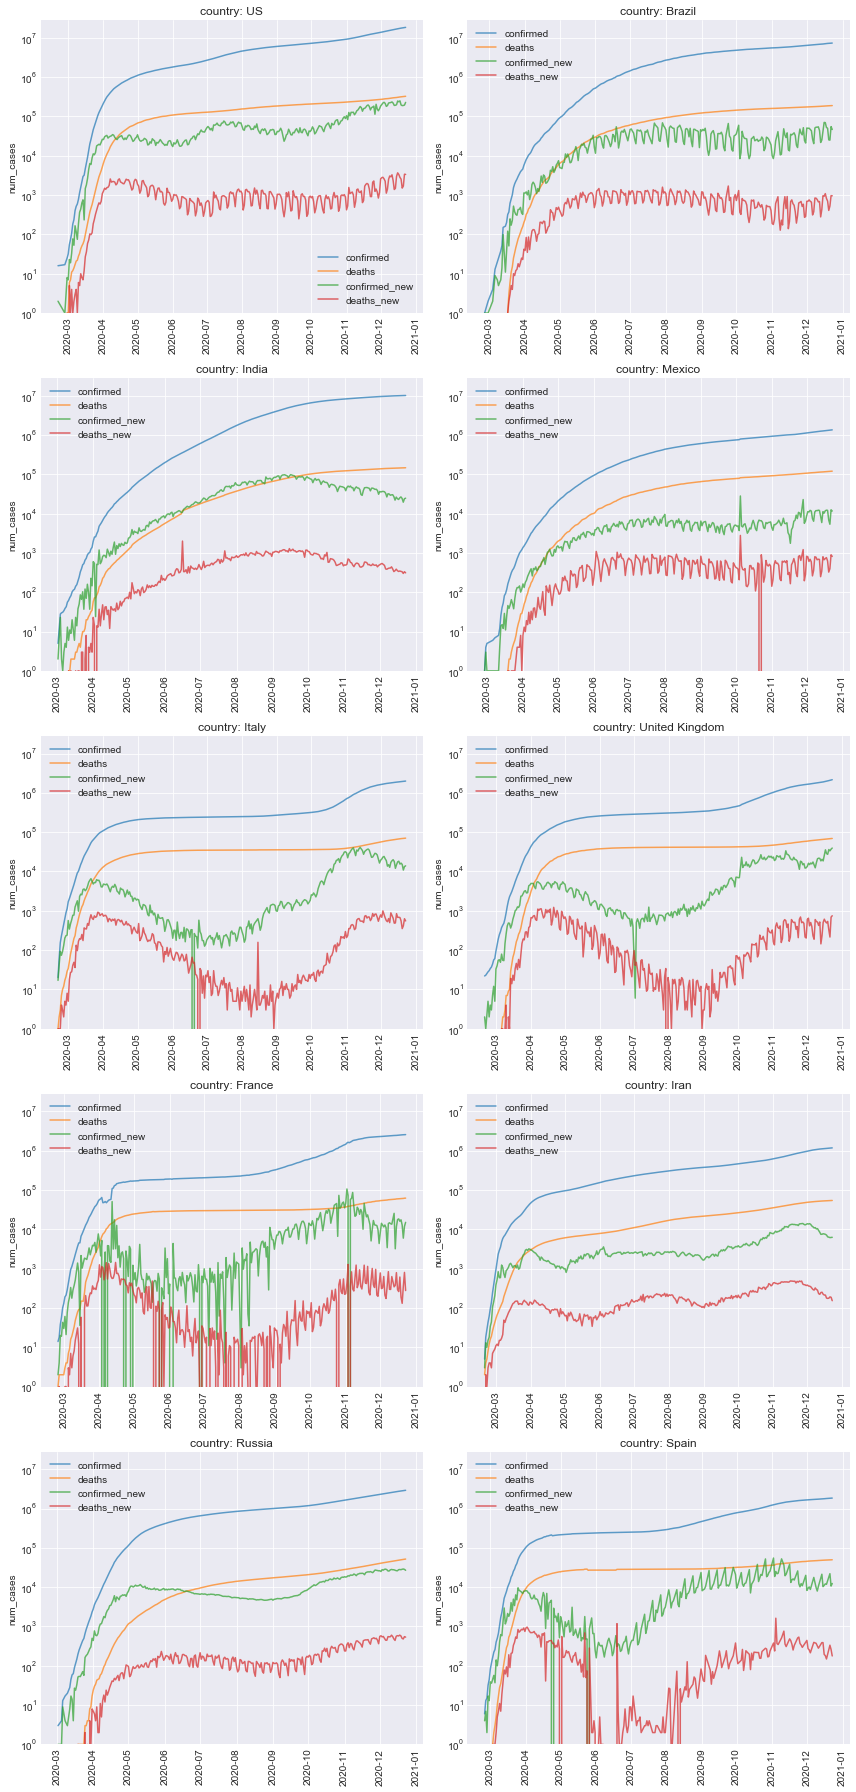

In [124]:
n_countries = 10

plot_countries(dfp_country, 
               countries=dfp_top_countries.iloc[:n_countries]['country'],
               plot_cols=['confirmed', 'deaths', 'confirmed_new', 'deaths_new'], #, 'recovered', 'active'
               country_col='country',
               date_min=datetime.datetime(2020,2,20),
              )

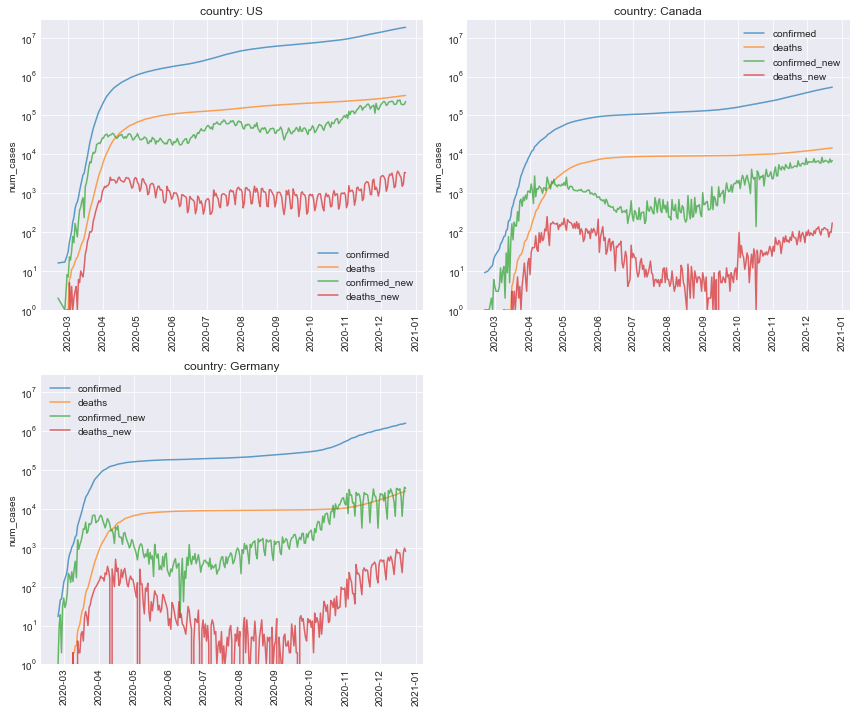

In [125]:
plot_countries(dfp_country, 
               countries=['US', 'Canada', 'Germany'],
               plot_cols=['confirmed', 'deaths', 'confirmed_new', 'deaths_new'], #, 'recovered', 'active'
               country_col='country',
               date_min=datetime.datetime(2020,2,20),
              )

<a id='forecasts_countries'></a>
# Forecasts of infections/deaths 1 and 7 days in the future

For confirmed cases (`confirmed_pred`) and deaths (`deaths_pred`)

In [126]:
def predict_from_fit(row):
    return int(10**(row['slope'] * row['unixtime'] + row['intercept']))

def shift_future(dfp, date_most_recent, days=1, cols_to_be_null_in_future=[]):
    dfp_most_recent = dfp.copy()
    dfp_most_recent['date'] = date_most_recent + datetime.timedelta(days=days)  #dfp_most_recent['date'] + datetime.timedelta(days=days)
    dfp_most_recent['unixtime'] = dfp_most_recent['date'].apply(datetime_to_unixtime)
    #dfp_most_recent['unixtime'] = dfp_most_recent['unixtime'] + 86400 * days
    
    cols_nullable = ['confirmed', 'deaths', 'recovered', 'active', 'confirmed_lag1', 'confirmed_new', 'deaths_new']
    cols_nullable.extend(cols_to_be_null_in_future)
    for col in cols_nullable:
        dfp_most_recent[col] = np.nan
    return dfp_most_recent

def fit_poly1(dfp_country_recent, 
              col_fit='confirmed_log', 
              col_pred='confirmed_pred', 
              date_most_recent=None,
              col_locale='country'
             ):
    warnings.simplefilter('ignore', np.RankWarning)
    if date_most_recent is None:
        date_most_recent = dfp_country_recent['date'].max()
    dfp_country_recent = dfp_country_recent.set_index(col_locale)
    
    # fit
    dfp_country_recent_clean = dfp_country_recent[(dfp_country_recent['date'] <= date_most_recent) &
                                                  (dfp_country_recent[col_fit] > 0)
                                                 ]
    dfp_country_confirmed_fit = (dfp_country_recent[dfp_country_recent['date'] <= date_most_recent].
                                 groupby([col_locale]).
                                 apply(lambda x: np.polyfit(x['unixtime'], x[col_fit], 1))
                                )
    dfp_country_recent['fits'] = dfp_country_confirmed_fit
    dfp_country_recent[['slope', 'intercept']] = dfp_country_recent['fits'].apply(pd.Series)   
    
    dfp_country_recent[col_pred] = dfp_country_recent.apply(predict_from_fit, axis=1)
    dfp_country_recent = dfp_country_recent.drop(columns=['fits', 'intercept']).reset_index() #'slope', 
    fit_col = col_fit.split('_')[0]
    dfp_country_recent[f"frac_increase_{fit_col}"] = (10**(dfp_country_recent['slope'] * 86400) - 1)
    #dfp_country_recent = dfp_country_recent.rename(columns={'slope': f'slope_{col_fit.split("_")[0]}'})
    return dfp_country_recent, dfp_country_confirmed_fit

def fit_exp(dfp_country, 
            n_days_predict=14, 
            n_days_into_future=[1,7],
            col_locale='country', 
            top_countries=None, 
            n_countries=10, 
            date_most_recent=None,
            is_silent=False
           ):
    # make predictions based on the last 2 weeks of data
    if date_most_recent is None:
        date_most_recent = dfp_country['date'].max()
    date_n_days_ago = date_most_recent - datetime.timedelta(days=n_days_predict-1)
    dfp_country_recent = (dfp_country[dfp_country['date'].between(date_n_days_ago, date_most_recent)].
                          sort_values(by=[col_locale, 'date'])
                         ).copy()

    # clean data for fit (convert to log)
    dfp_country_recent['confirmed_log'] = dfp_country_recent['confirmed'].apply(lambda x: np.log10(x) if x > 0 else 0)
    dfp_country_recent['deaths_log'] = dfp_country_recent['deaths'].apply(lambda x: np.log10(x) if x > 0 else 0)
    dfp_country_recent['unixtime'] = dfp_country_recent['date'].apply(datetime_to_unixtime)
    
    
    # make predictions to past, then future
    # add in future points
    dfp_country_recent_max_date = dfp_country_recent.groupby([col_locale], as_index=False).agg({'date': np.max})
    dfp_most_recent = dfp_country_recent.merge(dfp_country_recent_max_date, on=[col_locale, 'date'], how='inner').copy()
    #dfp_most_recent = dfp_country_recent[dfp_country_recent['date'] == date_most_recent].copy()
    list_dfp_recent = [dfp_country_recent]
    for n in n_days_into_future:
        dfp_most_recent_tmp = shift_future(dfp_most_recent, date_most_recent, n)
        list_dfp_recent.append(dfp_most_recent_tmp)
    #dfp_most_recent_7 = shift_future(dfp_most_recent, 7)
    #dfp_country_recent = pd.concat([dfp_country_recent, dfp_most_recent_1, dfp_most_recent_7], axis=0, sort=False)
    dfp_country_recent = pd.concat(list_dfp_recent, axis=0, sort=False)
    dfp_country_recent, dfp_country_deaths_fit = fit_poly1(dfp_country_recent, 
                                                           col_fit='deaths_log', 
                                                           col_pred='deaths_pred', 
                                                           col_locale=col_locale, 
                                                           date_most_recent=date_most_recent
                                                          )
    dfp_country_recent, dfp_country_confirmed_fit = fit_poly1(dfp_country_recent, 
                                                              col_fit='confirmed_log', 
                                                              col_pred='confirmed_pred', 
                                                              col_locale=col_locale, 
                                                              date_most_recent=date_most_recent
                                                             )
    dfp_country_recent['mortality_rate_pred'] = dfp_country_recent['deaths_pred'] / dfp_country_recent['confirmed_pred']

    # look only at the predictions for top countries
    if top_countries is None:
        top_countries = (dfp_most_recent.
                         sort_values(by='deaths', ascending=0).iloc[:n_countries][col_locale].values)
    dfp_forecasts = dfp_country_recent[(dfp_country_recent['date'] > date_most_recent)
                                       
                                      ].sort_values(by=[col_locale, 'date']).reset_index(drop=True)
    dfp_forecasts_out = dfp_forecasts[['date', 
                                       col_locale, 
                                       'confirmed_pred', 
                                       'deaths_pred', 
                                       'mortality_rate_pred', 
                                       'frac_increase_confirmed', 
                                       'frac_increase_deaths'
                                      ]].copy()
    dfp_forecasts_out['date'] = dfp_forecasts_out['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

    # find the daily fractional increase in cases
    dfp_frac_increase = (dfp_forecasts_out.
                         groupby([col_locale]).
                         agg({'frac_increase_confirmed': np.mean, 
                              'frac_increase_deaths': np.mean}))
    dfp_frac_increase.columns = pd.MultiIndex.from_product([dfp_frac_increase.columns, ['']])

    # pivot so each date of prediction has its own column
    dfp_forecasts_print = dfp_forecasts_out.pivot(index=col_locale, 
                                                  columns='date', 
                                                  values=['confirmed_pred', 'deaths_pred', 'mortality_rate_pred']
                                                 ).sort_values(by=('deaths_pred', dfp_forecasts_out['date'].min()), ascending=0)
    dfp_forecasts_print = dfp_forecasts_print.merge(dfp_frac_increase, on=col_locale, how='inner')
    if not is_silent:
        display(dfp_forecasts_print[dfp_forecasts_print.index.isin(top_countries)])
    return dfp_country_recent, dfp_forecasts_out


def plot_forecasts(dfp_country_recent, 
                   n_countries=10, 
                   n_columns=2, 
                   figsize=(12,24), 
                   date_min=datetime.datetime(2020, 2, 1),
                   col_locale='country',
                  ):
    # subset the top countries
    dfp_non_pred = dfp_country_recent.dropna(subset=['deaths'])
    dt_max = dfp_non_pred['date'].max()
    dfp_top_countries = (dfp_non_pred[dfp_non_pred['date'] == dt_max].
                         sort_values(by='deaths', ascending=0).
                         iloc[:n_countries]
                        )
    top_countries = (dfp_top_countries.
                     iloc[:n_countries][col_locale].values
                    )

    # plot the top countries
    i = 1
    n_rows = int(np.ceil(n_countries / n_columns))
    plt.figure(figsize=figsize)
    y_max = dfp_country_recent['confirmed_pred'].max()
    y_min = max(dfp_country_recent['deaths'].min(), 1)

    for country in top_countries:
        dfp_plot = dfp_country_recent[(dfp_country_recent[col_locale] == country) &
                               (dfp_country_recent['date'] >= date_min)
                              ].sort_values(by='date')
        plt.subplot(n_rows, n_columns, i)
        for key in ['confirmed', 'deaths']:
            p = plt.plot(dfp_plot['date'], dfp_plot[key], alpha=0.5, linewidth=2, label=key)
            pred_col = f'{key}_pred'
            plt.plot(dfp_plot['date'], dfp_plot[pred_col], linestyle='--', linewidth=2, alpha=0.5, color=p[0].get_color(), label=pred_col)
        plt.legend(loc='best')
        plt.ylabel('num cases')
        plt.title(f'{col_locale}: {country}')
        plt.yscale('log')
        plt.ylim([y_min, y_max])
        plt.xticks(rotation=90)

        i += 1
    plt.tight_layout()
    plt.show()
    return None
                       
                       
def save_forecast(dfp_forecasts_out, dfp_country_recent, n_days_training=14):
    date_most_recent = dfp_country_recent.dropna(subset=['deaths'])['date'].max()
    dfp_forecasts_out['date_of_forecast'] = date_most_recent
    save_name = f"covid-19_country_forecast_from_{date_most_recent.strftime('%Y-%m-%d')}_n_days_training={n_days_training}.csv"
    save_path = os.path.join('predictions', save_name)
    dfp_forecasts_out.to_csv(save_path, index=False)
    print(f'saved forecast to {save_path}')
    return None

##### Forecasts based on last 1 week

In [127]:
dfp_country_recent_1, dfp_forecasts_out_1 = fit_exp(dfp_country, 
                                                    n_days_predict=7,
                                                    n_days_into_future=[1,7,21], 
                                                    col_locale='country', 
                                                    top_countries=None
                                                   )
#plot_forecasts(dfp_country_recent_1)

confirmed_pred                         deaths_pred             \
date               2020-12-24  2020-12-30  2021-01-13  2020-12-24 2020-12-30   
country                                                                        
US                 18665851.0  19981480.0  23423256.0    327816.0   343061.0   
Brazil              7401434.0   7652636.0   8272431.0    189685.0   193934.0   
India              10148148.0  10293221.0  10639841.0    147100.0   149092.0   
Mexico              1358688.0   1419202.0   1571093.0    120717.0   124419.0   
Italy               2006926.0   2095284.0   2316876.0     70879.0    74081.0   
United Kingdom      2187180.0   2413413.0   3036509.0     69425.0    72368.0   
France              2575813.0   2654005.0   2845809.0     62404.0    64758.0   
Iran                1183786.0   1223448.0   1321239.0     54350.0    55449.0   
Russia              2935851.0   3117433.0   3586007.0     52384.0    55828.0   
Spain               1846848.0   1904016.0   2044385.0     49761.0    50698.0   

                          mortality_rate_pred                        \
date           2021-01-13          2020-12-24 2020-12-30 2021-01-13   
country                                                               
US               381446.0            0.017562   0.017169   0.016285   
Brazil           204223.0            0.025628   0.025342   0.024687   
India            153846.0            0.014495   0.014484   0.014459   
Mexico           133504.0            0.088848   0.087668   0.084975   
Italy             82125.0            0.035317   0.035356   0.035446   
United Kingdom    79731.0            0.031742   0.029986   0.026257   
France            70602.0            0.024227   0.024400   0.024809   
Iran              58101.0            0.045912   0.045322   0.043975   
Russia            64770.0            0.017843   0.017908   0.018062   
Spain             52954.0            0.026944   0.026627   0.025902   

               frac_increase_confirmed frac_increase_deaths  
date                                                         
country                                                      
US                            0.011416             0.007605  
Brazil                        0.005578             0.003699  
India                         0.002369             0.002244  
Mexico                        0.007289             0.005047  
Italy                         0.007207             0.007391  
United Kingdom                0.016540             0.006945  
France                        0.004997             0.006190  
Iran                          0.005508             0.003343  
Russia                        0.010052             0.010669  
Spain                         0.005094             0.003114

In [128]:
save_forecast(dfp_forecasts_out_1, dfp_country_recent_1, 7)

saved forecast to predictions/covid-19_country_forecast_from_2020-12-23_n_days_training=7.csv


<a id='country_relative_increases'></a>
### Relative increases per day by country

In [129]:
def find_relative_increase_data_and_plot(dfp_us_g, 
                                         n_days_fit=7, 
                                         dt=datetime.datetime(2020,3,10),
                                         n_locales=7,
                                         col_locale='state'
                                        ):
    dt_max = dfp_us_g['date'].max()
    list_dfp_state_relative = []
    while dt <= dt_max:
        try:
            dfp_state_recent_tmp, dfp_state_forecasts_out_tmp = fit_exp(dfp_us_g, 
                                                                        n_days_predict=n_days_fit, 
                                                                        col_locale=col_locale, 
                                                                        top_countries=None,
                                                                        date_most_recent=dt,
                                                                        is_silent=True
                                                                       )
            dfp_state_recent_tmp = dfp_state_recent_tmp.dropna(subset=['confirmed'])
            dfp_state_recent_tmp_single = dfp_state_recent_tmp[dfp_state_recent_tmp['date'] == dfp_state_recent_tmp['date'].max()]
            list_dfp_state_relative.append(dfp_state_recent_tmp_single)
        except Exception as e:
            print(f"failed on {dt.strftime('%Y-%m-%d')}")

        dt += datetime.timedelta(days=1)
    dfp_state_relative_chng = pd.concat(list_dfp_state_relative)
                  
    # plot states
    top_states = (dfp_state_relative_chng[(dfp_state_relative_chng['date'] == dfp_state_relative_chng['date'].max())].
                  sort_values(by='deaths', ascending=0).
                  reset_index(drop=True).
                  iloc[:n_locales][col_locale].values
                 )
                  
    # deaths
    plt.subplot(1,2,1)
    for state in top_states:
        dfp_st = dfp_state_relative_chng[(dfp_state_relative_chng[col_locale] == state) & 
                                         (dfp_state_relative_chng['deaths'] > 2)]
        #
        plt.plot(dfp_st['date'], dfp_st['frac_increase_deaths'], label=state, alpha=0.7)
        plt.ylabel('relative increase in deaths')
        plt.xticks(rotation=90)
        plt.legend(loc='best')
        plt.axhline(0, color='k', alpha=0.5)
        plt.title('Relative daily increase in deaths')

    # confirmed cases
    plt.subplot(1,2,2)
    for state in top_states:
        dfp_st = dfp_state_relative_chng[(dfp_state_relative_chng[col_locale] == state) & 
                                         (dfp_state_relative_chng['deaths'] > 2)]
        
        plt.plot(dfp_st['date'], dfp_st['frac_increase_confirmed'], label=state, alpha=0.7)
        plt.ylabel('relative increase in confirmed')
        plt.xticks(rotation=90)
        plt.legend(loc='best')
        plt.axhline(0, color='k', alpha=0.5)
        plt.title('Relative daily increase in confirmed')

    plt.show()
    return None


In [130]:
now = datetime.datetime.now()
now = datetime.datetime(now.year, now.month, now.day)
n_days_back = 21
dt_start = now - datetime.timedelta(days=n_days_back)
#dt_start = datetime.datetime(2020,3,2)
#find_relative_increase_data_and_plot(dfp_country, n_locales=8, col_locale='country', dt=dt_start)

##### Forecasts based on last 2 weeks

In [131]:
dfp_country_recent_2, dfp_forecasts_out_2 = fit_exp(dfp_country, 
                                                    n_days_predict=14, 
                                                    col_locale='country', 
                                                    top_countries=None
                                                   )
#plot_forecasts(dfp_country_recent_2)

confirmed_pred             deaths_pred             \
date               2020-12-24  2020-12-30  2020-12-24 2020-12-30   
country                                                            
US                 18742652.0  20202947.0    328556.0   345408.0   
Brazil              7420764.0   7714043.0    189813.0   194408.0   
India              10153466.0  10306111.0    147202.0   149350.0   
Mexico              1361374.0   1427055.0    120746.0   124558.0   
Italy               2015382.0   2118178.0     71309.0    75266.0   
United Kingdom      2166142.0   2357186.0     69359.0    72250.0   
France              2579062.0   2665099.0     62473.0    64935.0   
Iran                1187772.0   1233829.0     54471.0    55755.0   
Russia              2937394.0   3121276.0     52500.0    56164.0   
Spain               1847948.0   1907729.0     49877.0    50997.0   

               mortality_rate_pred            frac_increase_confirmed  \
date                    2020-12-24 2020-12-30                           
country                                                                 
US                        0.017530   0.017097                0.012583   
Brazil                    0.025579   0.025202                0.006481   
India                     0.014498   0.014491                0.002490   
Mexico                    0.088694   0.087283                0.007884   
Italy                     0.035382   0.035533                0.008326   
United Kingdom            0.032020   0.030651                0.014187   
France                    0.024223   0.024365                0.005484   
Iran                      0.045860   0.045189                0.006361   
Russia                    0.017873   0.017994                0.010171   
Spain                     0.026990   0.026732                0.005320   

               frac_increase_deaths  
date                                 
country                              
US                         0.008371  
Brazil                     0.003994  
India                      0.002417  
Mexico                     0.005194  
Italy                      0.009042  
United Kingdom             0.006830  
France                     0.006463  
Iran                       0.003893  
Russia                     0.011309  
Spain                      0.003706

In [132]:
save_forecast(dfp_forecasts_out_2, dfp_country_recent_2, 14)

saved forecast to predictions/covid-19_country_forecast_from_2020-12-23_n_days_training=14.csv


<a id='time-series_country_mortality'></a>
# Time-series plots of mortality

In [133]:
def plot_mortality_rate(
    dfp, 
    locales, 
    id_col='country', 
    upper_lim=0.2, 
    date_min=datetime.datetime(2020,2,20),
    dfp_country_mortality_expected=None
):
    
    for locale in locales:
        dfp_plot = dfp[(dfp[id_col] == locale) &
                       (dfp['date'] >= date_min)
                      ]
        p = plt.plot(dfp_plot['date'], dfp_plot['mortality_rate'], label=locale, alpha=0.7)
        
        if dfp_country_mortality_expected is not None:
            dfp_expected = dfp_country_mortality_expected[dfp_country_mortality_expected['country'] == locale]
            
            color = p[0].get_color()
            expected = dfp_expected['frac_mortality'].values[0]
            plt.axhline(expected, 
                        color=color, 
                        alpha=0.5, 
                        linestyle='--', 
                        label=f'{locale} expected = {expected:0.4f}'
                       )
    #plt.legend(loc='best')
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
    if upper_lim is not None:
        plt.ylim([0,upper_lim])
    #plt.yscale('log')
    plt.ylabel('mortality rate')
    plt.title(f'Mortality by {id_col}')
    plt.xticks(rotation=90)
    plt.show()
    return None

In [134]:
# n_countries = 8
# countries = dfp_top_countries.iloc[:n_countries]['country']

# plot_mortality_rate(dfp_country, countries, upper_lim=0.2, id_col='country', date_min=datetime.datetime(2020,3,1))

### Is mortality rate a function of number of infections?

In [135]:
def plot_mortality_rate_vs_infections(
    dfp, 
    locales, 
    id_col='country', 
    upper_lim=0.2, 
    date_min=datetime.datetime(2020,2,20),
    x_col='confirmed',
    y_col='mortality_rate'
):
    
    for locale in locales:
        dfp_plot = dfp[(dfp[id_col] == locale) &
                       (dfp['date'] >= date_min)
                      ]
        plt.plot(dfp_plot[x_col], dfp_plot[y_col], 'o', label=locale, alpha=0.3)
    plt.legend(loc='best')
    #plt.ylim([0,upper_lim])
    plt.gca().set_ylim(top=upper_lim)
    plt.xscale('log')
    #plt.yscale('log')
    #plt.xlabel('# confirmed cases')
    #plt.ylabel('mortality rate')
    plt.xlabel(x_col.replace('_', ' '))
    plt.ylabel(y_col.replace('_', ' '))
    plt.title(f'{y_col} vs {x_col} by {id_col}')
    plt.xticks(rotation=90)
    plt.show()
    return None

In [136]:
# plot_mortality_rate_vs_infections(dfp_country, countries, upper_lim=0.2, id_col='country', date_min=datetime.datetime(2020,3,1))

# Compare mortality rate to expected given country demographics and mortality by age data?

- Country demographic data source: https://www.census.gov/data-tools/demo/idb/region.php?T=10&RT=0&A=both&Y=2020&C=AF&R=1
- Mortality by age source: https://www.worldometers.info/coronavirus/coronavirus-age-sex-demographics/

In [137]:
dfp_3codes = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2014_world_gdp_with_codes.csv')
dfp_3codes.columns = list([x.lower() for x in dfp_3codes.columns])
dfp_3codes = dfp_3codes.rename(columns={'code': 'country_code'})

In [138]:
# mortality data
d_mortality = {0: 0, 10: 0.002, 20: 0.002, 30: 0.002, 40: 0.004, 50: 0.013, 60: 0.036, 70: 0.08, 80: 0.148, 90: 0.148, 100: 0.148}
dfp_mortality = pd.DataFrame.from_dict(d_mortality, orient='index', columns=['mortality_rate']).reset_index(drop=False)
dfp_mortality = dfp_mortality.rename(columns={'index': 'age_decade'})

# demographic data
dfp_demo = pd.read_csv('supporting_data/census_data_20200320_10a682338c.csv', skiprows=1, skipinitialspace=True)

# clean demographic data
dfp_demo = dfp_demo[(dfp_demo['Region'] == 'World') & (dfp_demo['Age'] != 'Total')]
dfp_demo['age_min'] = dfp_demo['Age'].apply(lambda x: np.min([int(y) for y in re.findall('(\d+)', x)]))
dfp_demo['age_mid'] = dfp_demo['age_min'] + 2.5
dfp_demo['age_decade'] = dfp_demo['age_min'].apply(lambda x: int(x / 10) * 10)
dfp_demo = dfp_demo.rename(columns={'Percent Both Sexes': 'pct_pop', 
                                    'Country': 'country',
                                    'Both Sexes Population': 'pop'
                                   })
dfp_demo_decade = dfp_demo.groupby(['country', 'age_decade'], as_index=False).agg({'pct_pop': np.sum, 'pop': np.sum})

# decorate with country codes
dfp_demo_decade = dfp_demo_decade.merge(dfp_3codes[['country', 'country_code']], on='country', how='left')

# ensure consistency with Johns Hopkins data
dfp_demo_decade.loc[dfp_demo_decade['country'] == 'United States', 'country'] = 'US'

# join mortality with demographics
dfp_demo_decade_mortality = (dfp_demo_decade.merge(dfp_mortality, on=['age_decade'], how='inner').
                             sort_values(by=['country', 'age_decade']).
                             reset_index(drop=True)
                            )
dfp_demo_decade_mortality['frac_mortality'] = dfp_demo_decade_mortality['pct_pop'] * dfp_demo_decade_mortality['mortality_rate'] / 100
dfp_demo_decade_mortality['num_deaths_max_expected'] = dfp_demo_decade_mortality['pop'] * dfp_demo_decade_mortality['mortality_rate']

grouping_cols_country = ['country', 'country_code']
dfp_country_mortality_expected = (dfp_demo_decade_mortality.
                                  groupby(grouping_cols_country, as_index=False).
                                  agg({'frac_mortality': np.sum, 
                                       'num_deaths_max_expected': np.sum, 
                                       'pop': np.sum
                                      })
                                 )
dfp_country_mortality_expected.loc[dfp_country_mortality_expected['country'] == 'United States', 'country'] = 'US'

### Age distributions for most infected countries

In [139]:
# n_countries = 8
# countries = dfp_top_countries.iloc[:n_countries]['country']
# for country in countries:
#     dfp_plot = dfp_demo[dfp_demo.country == country]
#     plt.plot(dfp_plot['age_mid'], dfp_plot['pct_pop'], alpha=0.7, label=country)
# plt.xlabel('age')
# plt.ylabel('% of population')
# plt.title('Age distribution by country')
# plt.legend(loc='best')
# plt.show()

<a id='counry_mortality_expectations'></a>
### Mortality as currently measured, compared to expected based on WHO mortality expectations

In [140]:
# n_countries = 10
# countries = dfp_top_countries.iloc[:n_countries]['country']

# plot_mortality_rate(dfp_country, countries, upper_lim=None, id_col='country', date_min=datetime.datetime(2020,3,1), dfp_country_mortality_expected=dfp_country_mortality_expected)
# dfp_display = (dfp_country[(dfp_country['date'] == dfp_country['date'].max()) & 
#                            (dfp_country['country'].isin(countries))
#                           ].
#                sort_values(by='mortality_rate', ascending=0).
#                reset_index(drop=True)
#               )[['date', 'country', 'mortality_rate', 'confirmed', 'deaths']]
# display(dfp_display)

**Remarks about the mortality rate being above the expected mortality rate**

Assuming the [cited report](https://www.worldometers.info/coronavirus/coronavirus-age-sex-demographics/) of age-wise mortality is correct and that the virus is homogeneously distributed amongst the population, a discrepancy like this could arise if the country has:
- Preferentially tested people in critical condition, ignoring test for mild cases (perhaps if testing capacity is saturated)
- An overloaded hospital system, where patients are not receiving the same quality of care they would otherwise

If the testing is biased, we can estimate the true number of infections by multiplying the confirmed cases by the ratio between the measured mortality rate and the expected mortality rate.  For example, in Iran (as of 2020-03-22), we might estimate the true number of cases is 9.3x higher using this method (200,589 vs 21,638).

### Distribution of expected mortality fractions

In [141]:
# dfp_country_mortality_expected['frac_mortality'].hist(bins=np.linspace(0,0.04,30))
# plt.title('Distribution of mortality fraction')
# plt.ylabel('number of countries')
# plt.xlabel('mortality fraction')
# plt.show()

### Top expected mortality fractions based on age demographics
For countries with populations greater than 10 million.

In [142]:
dfp_country_mortality_expected = dfp_country_mortality_expected.sort_values(by='frac_mortality', ascending=0).reset_index(drop=True)
dfp_country_mortality_expected[dfp_country_mortality_expected['pop'] > 1E7].head(10)

country country_code  frac_mortality  num_deaths_max_expected  \
1         Japan          JPN        0.031837              3998380.024   
2       Germany          DEU        0.026398              2128411.026   
3        Greece          GRC        0.025745               271233.247   
4         Italy          ITA        0.025637              1599267.592   
10     Portugal          PRT        0.023736               244829.259   
18       France          FRA        0.022950              1564984.503   
20       Sweden          SWE        0.022575               231555.716   
23      Belgium          BEL        0.022146               259573.363   
24  Netherlands          NLD        0.022076               382222.125   
27       Canada          CAN        0.021712               820035.480   

          pop  
1   125507472  
2    80159662  
3    10607051  
4    62402659  
10   10302674  
18   67848156  
20   10202491  
23   11720716  
24   17280397  
27   37694085

<a id='density_of_infections_by_country'></a>
# Density of infections per million people

In [143]:
# plot of country fractions that are infected
dfp_country_pop = dfp_country.merge(dfp_country_mortality_expected[grouping_cols_country + ['pop']], on='country', how='left').copy()
dfp_country_pop['deaths_per_million'] = dfp_country_pop['deaths'] / dfp_country_pop['pop'] * 1E6
dfp_country_pop['confirmed_per_million'] = dfp_country_pop['confirmed'] / dfp_country_pop['pop'] * 1E6

# new infections
dfp_country_pop['deaths_new_per_million'] = dfp_country_pop['deaths_new'] / dfp_country_pop['pop'] * 1E6
dfp_country_pop['confirmed_new_per_million'] = dfp_country_pop['confirmed_new'] / dfp_country_pop['pop'] * 1E6
dfp_country_pop['deaths_new_per_million_smooth'] = dfp_country_pop['deaths_new_smooth'] / dfp_country_pop['pop'] * 1E6
dfp_country_pop['confirmed_new_per_million_smooth'] = dfp_country_pop['confirmed_new_smooth'] / dfp_country_pop['pop'] * 1E6

### Map: new confirmed cases and deaths

In [144]:
def plot_world_map(df, plot_col, color='Reds', col_country='country_code'):
    # this was adapted from example at https://plotly.com/python/choropleth-maps/
    import plotly.graph_objects as go
    fig = go.Figure(data=go.Choropleth(
        locations=df[col_country], #df['code'], # Spatial coordinates
        z = df[plot_col].astype(float), # Data to be color-coded
        #locationmode = 'USA-states', # set of locations match entries in `locations`
        colorscale = color,
        colorbar_title = plot_col,
    ))

    fig.update_layout(
        title_text = plot_col,
        #geo_scope='usa', # limite map scope to USA
    )

    fig.show()
    return None

In [145]:
plot_world_map(dfp_country_pop[dfp_country_pop.date == ds_latest], 'confirmed_new_per_million_smooth')

In [146]:
plot_world_map(dfp_country_pop[dfp_country_pop.date == ds_latest], 'deaths_new_per_million_smooth')

In [147]:
def plot_smoothed_trend(
    dfp_us_g, 
    states, 
    cols_plot=['confirmed_new'], 
    dt_start=datetime.datetime(2020,3,1), 
    state_col='state'
):
    
    for state in states:
        i = 1
        for col_plot in cols_plot:
            plt.subplot(1,len(cols_plot),i)
            col_plot_smooth = f'{col_plot}_smooth'
            dfp_plot = dfp_us_g[(dfp_us_g[state_col] == state) & (dfp_us_g['date'] >= dt_start)]
            plt.plot(dfp_plot['date'], dfp_plot[col_plot], alpha=0.5, label=col_plot)
            plt.plot(dfp_plot['date'], dfp_plot[col_plot_smooth], label=col_plot_smooth)
            plt.legend(loc='best')
            plt.xticks(rotation=90)
            plt.ylabel(col_plot)
            plt.title(f'{state} {col_plot}')
            plt.ylim(ymin=0)
            i += 1
        plt.tight_layout()
        plt.show()
    return None

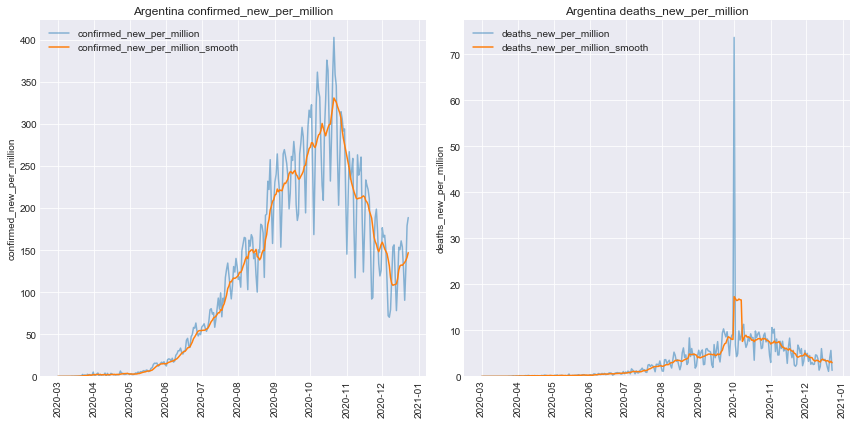

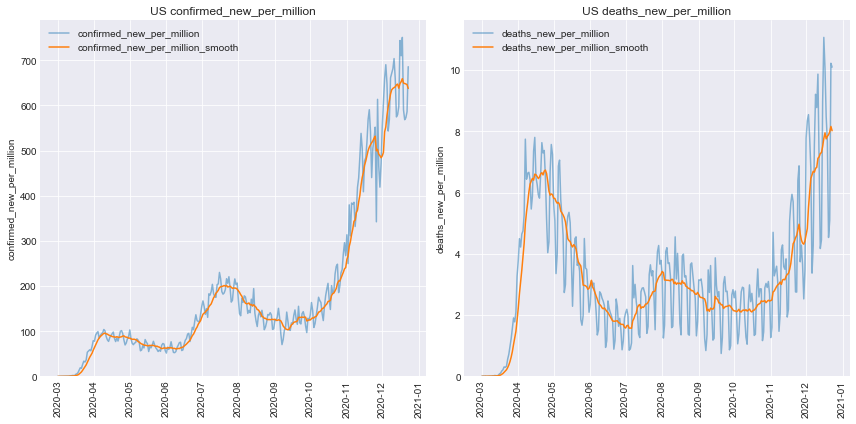

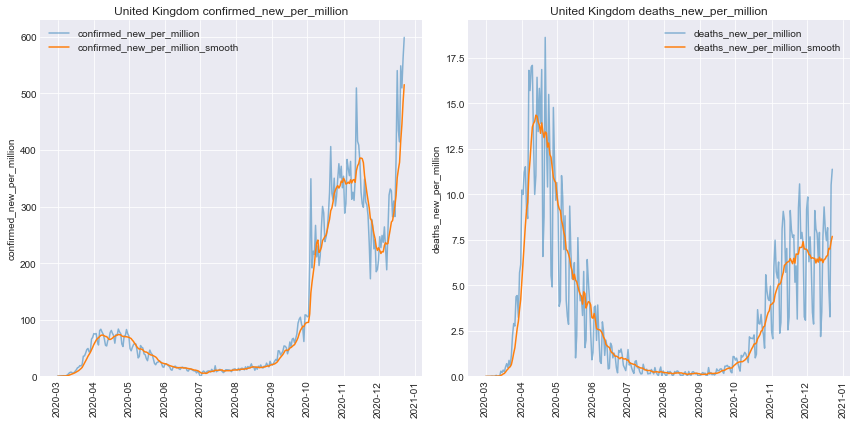

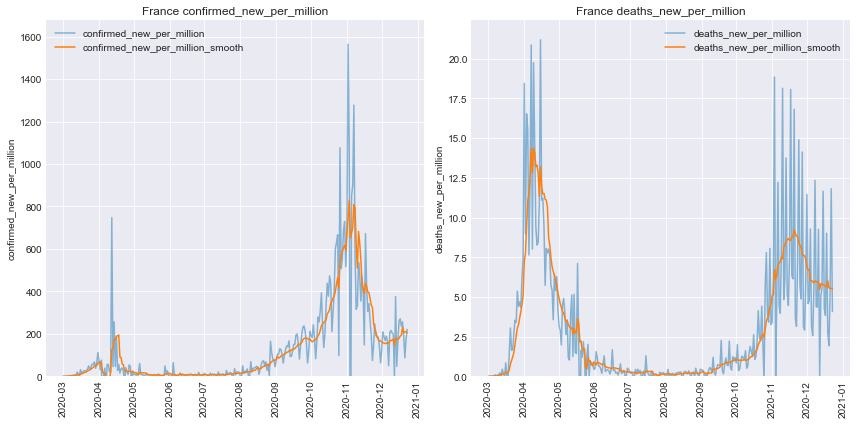

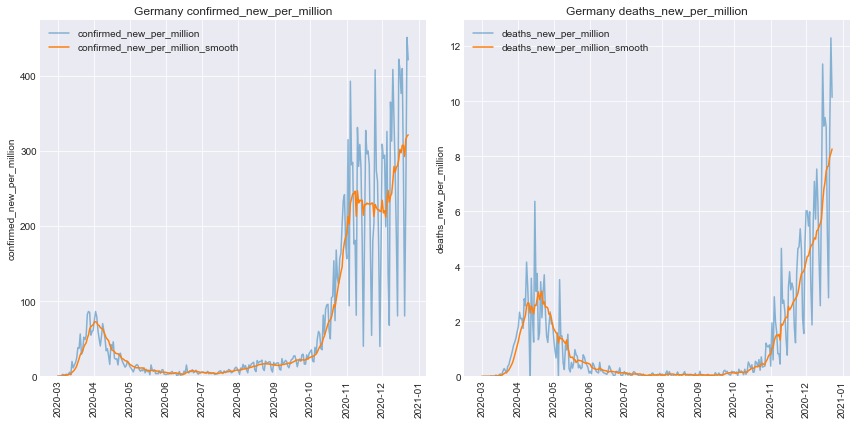

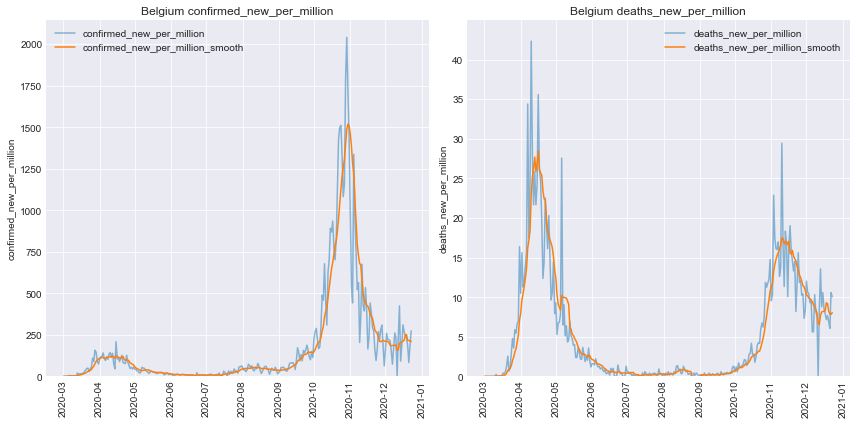

In [148]:
plot_smoothed_trend(
    dfp_country_pop, 
    state_col='country', 
    states=['Argentina', 'US', 'United Kingdom', 'France', 'Germany', 'Belgium'], 
    cols_plot=['confirmed_new_per_million', 'deaths_new_per_million']
)

##### Top countries by per-capita

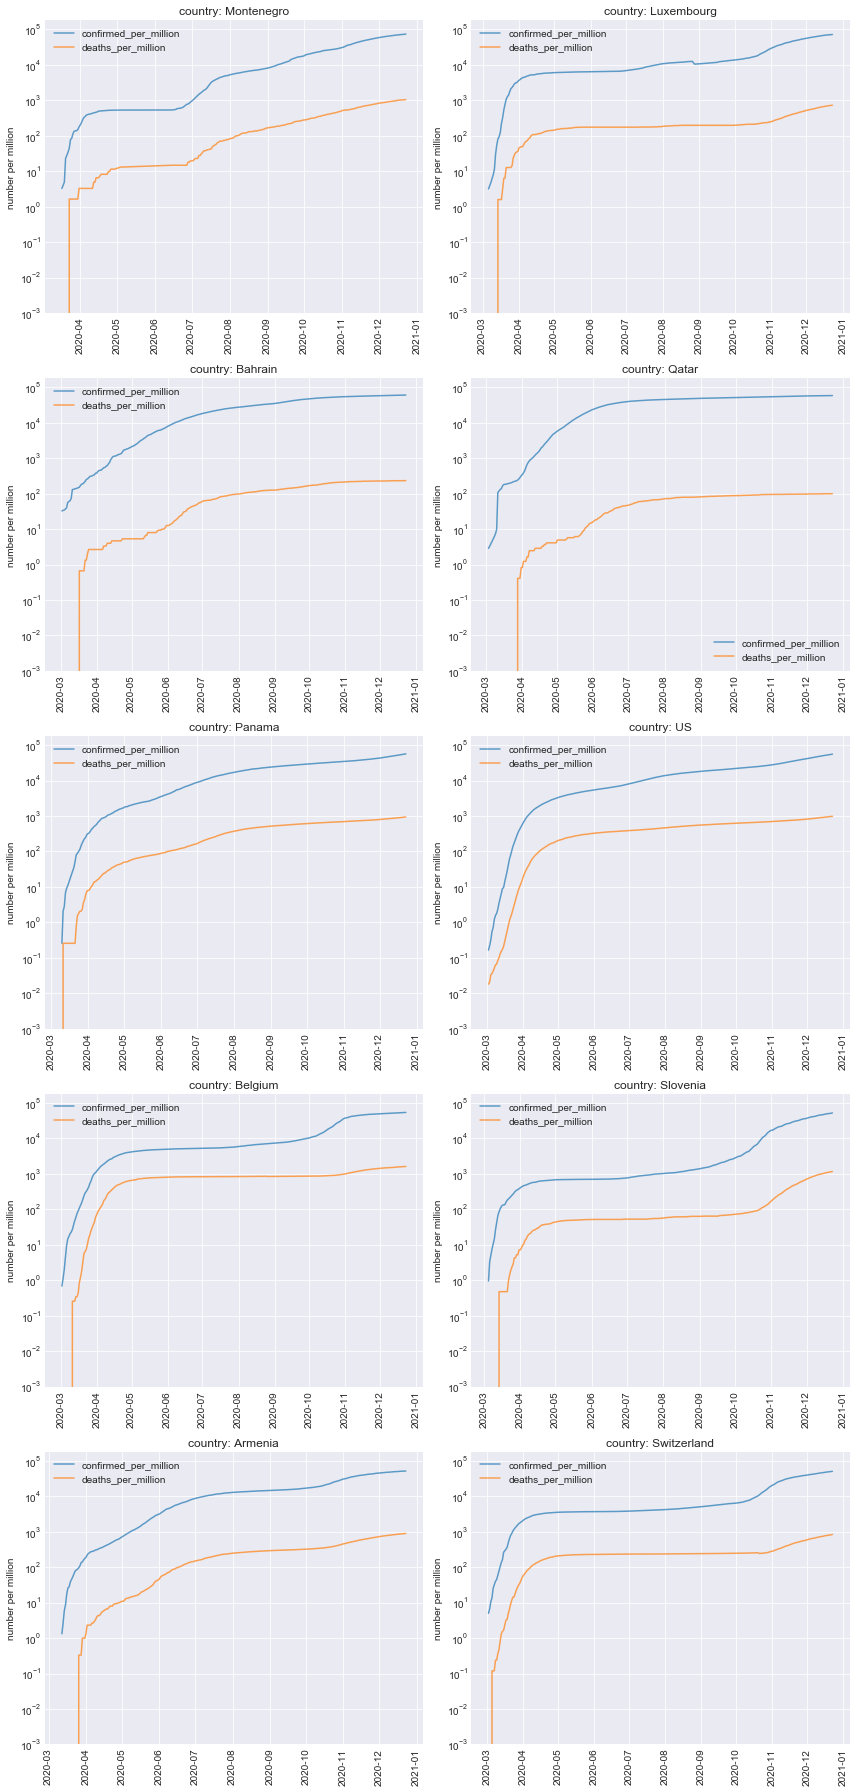

country   population   confirmed    deaths  confirmed_per_million  \
0   Montenegro     609859.0     45062.0     639.0           73889.210457   
1   Luxembourg     628381.0     45209.0     458.0           71945.205218   
2      Bahrain    1505003.0     90817.0     350.0           60343.401309   
3        Qatar    2444174.0    142448.0     243.0           58280.629775   
4       Panama    3894082.0    220261.0    3664.0           56563.010229   
5           US  332639102.0  18458373.0  326124.0           55490.689125   
6      Belgium   11720716.0    632321.0   18939.0           53949.007893   
7     Slovenia    2102678.0    109934.0    2454.0           52282.850727   
8      Armenia    3021324.0    155440.0    2691.0           51447.643483   
9  Switzerland    8403994.0    423299.0    7029.0           50368.788935   

   deaths_per_million  mortality_rate  
0         1047.783176        0.014180  
1          728.857174        0.010131  
2          232.557676        0.003854  
3           99.420090        0.001706  
4          940.914958        0.016635  
5          980.413902        0.017668  
6         1615.856915        0.029952  
7         1167.083120        0.022322  
8          890.669124        0.017312  
9          836.388032        0.016605

In [149]:
n_countries = 10
dfp_country_pop_top = (dfp_country_pop[(dfp_country_pop['date'] == dfp_country_pop['date'].max()) &
                                       (dfp_country_pop['pop'] >= 1E5)
                                      ].
                       sort_values(by='confirmed_per_million', ascending=0).
                       reset_index(drop=True)
                      )

plot_countries(dfp_country_pop, 
               countries=dfp_country_pop_top.iloc[:n_countries]['country'],
               plot_cols=['confirmed_per_million', 'deaths_per_million'],
               country_col='country',
               y_max=dfp_country_pop['confirmed_per_million'].max()*2,
               y_min=0.001,
               y_label='number per million',
               date_min=datetime.datetime(2020,3,2)
              )
display_cols = ['country', 'pop', 'confirmed', 'deaths', 'confirmed_per_million', 'deaths_per_million', 'mortality_rate']
display(dfp_country_pop_top[display_cols].rename(columns={'pop': 'population'}).head(10))

In [150]:
dfp_country_pop_top[display_cols].sort_values(by='deaths_per_million', ascending=0).head(10)

country          pop   confirmed    deaths  \
6                  Belgium   11720716.0    632321.0   18939.0   
7                 Slovenia    2102678.0    109934.0    2454.0   
34                    Peru   31914989.0   1000153.0   37218.0   
30                   Italy   62402659.0   1991278.0   70395.0   
27          United Kingdom   65761117.0   2155996.0   69157.0   
0               Montenegro     609859.0     45062.0     639.0   
38                Bulgaria    6966899.0    195886.0    6978.0   
39  Bosnia and Herzegovina    3835586.0    107570.0    3838.0   
22                   Spain   50015792.0   1842289.0   49698.0   
5                       US  332639102.0  18458373.0  326124.0   

    confirmed_per_million  deaths_per_million  mortality_rate  
6            53949.007893         1615.856915        0.029952  
7            52282.850727         1167.083120        0.022322  
34           31338.033674         1166.160515        0.037212  
30           31910.146649         1128.076930        0.035352  
27           32785.270360         1051.639679        0.032077  
0            73889.210457         1047.783176        0.014180  
38           28116.669985         1001.593392        0.035623  
39           28045.258273         1000.629369        0.035679  
22           36834.146303          993.646167        0.026976  
5            55490.689125          980.413902        0.017668

### Mortality rate by deaths per capita, confirmed per capita

In [151]:
# plot_mortality_rate_vs_infections(dfp_country_pop, 
#                                   countries, 
#                                   upper_lim=0.2, 
#                                   id_col='country', 
#                                   date_min=datetime.datetime(2020,3,1), 
#                                   x_col='deaths_per_million', 
#                                   y_col='mortality_rate'
#                                  )

In [152]:
# plot_mortality_rate_vs_infections(dfp_country_pop, 
#                                   countries, 
#                                   upper_lim=0.2, 
#                                   id_col='country', 
#                                   date_min=datetime.datetime(2020,3,1), 
#                                   x_col='confirmed_per_million', 
#                                   y_col='mortality_rate'
#                                  )

<a id='days_behind'></a>
# How many days behind is each country from Italy?

In [153]:
def days_behind_multi_country(
    countries_compare, 
    country_base, 
    dfp=dfp_country_pop, 
    n_days=14, 
    country_col='country',
    compare_col='confirmed_frac'
):
#     country_compare = 'Spain'
#     country_base = 'Italy'
    countries = [country_base] + countries_compare
    #n_days = 14  # compare the lag over the last n_days

    # compare the fraction of cases directly
    list_dfp_compare = []
    d_dfp_compare = {}

    for i, country in enumerate(countries):
        dfp_p = dfp[dfp[country_col] == country]
        dfp_p = dfp_p.sort_values(by='date', ascending=0).reset_index(drop=True)
        
        if country == country_base:
            line_style = '-'
            dfp_comp = dfp_p.copy()
            alpha=1
        else:
            line_style = '--'
            list_dfp_compare.append(dfp_p)
            d_dfp_compare[country] = dfp_p
            alpha=0.7
        
        plt.plot(dfp_p['date'], dfp_p['confirmed'], linestyle=line_style, alpha=alpha, label=country)
        
    plt.legend(loc='best')
    plt.title('Raw number of cases')
    plt.ylabel('cases')
    plt.yscale('log')
    plt.show()


    # compute the best estimate of the lag between countries
    # this assumes that the best metric is density of cases
    # though this may be more dependent on localities
    metric = compare_col
    delta_col = f'delta_{metric}'
    list_series = []

    for country, dfp_test in d_dfp_compare.items():
        list_series = []
        delta_col = f'delta_{metric}_{country}'
        for i, row in dfp_test[:n_days].iterrows():
            dfp_comp[delta_col] = np.abs(dfp_comp[metric] - row[metric])
            min_loc = dfp_comp[delta_col] == dfp_comp[delta_col].min()
            #print(row['date'] - dfp_comp[min_loc]['date'])
            days_diff = pd.to_timedelta(row['date'] - dfp_comp[min_loc]['date']).astype('timedelta64[D]').values[0]
            row['days_diff'] = days_diff
            row['country_compare'] = country
            list_series.append(row)

        # plot days behind
        dfp_days_behind = pd.concat(list_series, axis=1).T
        plt.plot(dfp_days_behind['date'], dfp_days_behind['days_diff'], label=country, alpha=0.5)
        mean_days_diff = dfp_days_behind['days_diff'].mean()#{str(dfp['date'].max())}
        date_max = dfp['date'].max().strftime('%Y-%m-%d')
    plt.axhline(0, label='0', color='k', linestyle='--', alpha=0.5)
    #print(f'Computing how far behind a country is using the {compare_col} column:')
    plt.title(f'Number days each {country_col} is from {country_base} as of {date_max} using {compare_col}')
    plt.ylabel('# days')
    plt.legend(loc='best')
    plt.show()
    return dfp_days_behind

##### Days behind Italy via density of cases

In [154]:
# _ = days_behind_multi_country(['Spain', 'France', 'Germany', 'United Kingdom', 'US'], 'Italy', dfp=dfp_country_pop, compare_col='confirmed_per_million')

##### Days behind Italy via number of confirmed cases

In [155]:
# _ = days_behind_multi_country(['Spain', 'France', 'Germany', 'United Kingdom', 'US'], 'Italy', dfp=dfp_country_pop, compare_col='confirmed')

# US state breakdown

In [156]:
# # load and clean data
# dfp_us_raw = pd.read_csv('state_data/states-daily.csv')
# dfp_us_raw = dfp_us_raw.rename(columns={'state': 'state_clean_1',
#                                         'positive': 'confirmed',
#                                         'death': 'deaths',
#                                         'date': 'date_str'
#                                        })
# dfp_us_raw['date'] = dfp_us_raw['date_str'].apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
# dfp_us_raw['country'] = 'US'

In [157]:
# load and clean data from CSSEGIS
state_base_dir = '../COVID-19/csse_covid_19_data/csse_covid_19_daily_reports_us/'
data_paths_raw = os.listdir(state_base_dir)
data_paths = [path for path in data_paths_raw if path.endswith('csv')]
list_dfp_states = []
cols_of_interest = ['country', 'state', 'date', 'confirmed', 'deaths', 'recovered', 'people_hospitalized']
for path in data_paths:
    full_path = os.path.join(state_base_dir, path)
    
    # read state data
    dfp_temp = pd.read_csv(full_path)
    cols = list(dfp_temp.columns)
    
    # clean column names
    cols_translate = {'Country/Region': 'country',
                      'Province/State': 'state',
                      'Confirmed': 'confirmed',
                      'Deaths': 'deaths',
                      'Recovered': 'recovered',
                      'Country_Region': 'country',
                      'Province_State': 'state',
                      'Last_Update': 'Last Update',
                      'People_Hospitalized': 'people_hospitalized'
                     }
    dfp_temp = dfp_temp.rename(columns=cols_translate)
    #dfp_temp['date'] = dfp_temp['Last Update'].apply(lambda x: parser.parse(x).date())
    
    dfp_temp['date'] = datetime.datetime.strptime(path.split('.')[0], '%m-%d-%Y')
    #dfp_temp['date'] = dfp_temp['date'].apply(lambda x: datetime.datetime(x.year, x.month, x.day))
    dfp_temp = dfp_temp[dfp_temp['country'] == 'US']
    list_dfp_states.append(dfp_temp[cols_of_interest])
dfp_us_raw = pd.concat(list_dfp_states)
dfp_us_raw['state_clean_1'] = dfp_us_raw['state'].apply(lambda x: re.findall('\, ([A-Z]{2}$)', x)[0].strip() if re.findall('\, ([A-Z]{2}$)', x) else x)

In [158]:
# look only at the US
#dfp_us_raw = dfp[dfp['country'] == 'US'].copy()
#dfp_us_raw['state_clean_1'] = dfp_us_raw['state'].apply(lambda x: re.findall('\, ([A-Z]{2})', x)[0].strip() if re.findall('\, ([A-Z]{2})', x) else x)

# load codes to convert two-letter codes to state names
dfp_state_codes = pd.read_csv('supporting_data/us_state_to_two_letter_code.csv')
dfp_state_codes = dfp_state_codes.rename(columns={'state': 'state_name'})
dfp_us = dfp_us_raw.merge(dfp_state_codes, left_on=['state_clean_1'], right_on=['two_letter_code'], how='left')
# dfp_us['abbrev'] = ~dfp_us['state_name'].isnull()
# dfp_us['state_clean'] = dfp_us.apply(lambda x: x['state_name'] if x['abbrev'] else x['state_clean_1'], axis=1)

# # aggregate infections by state
# dfp_us_g = (dfp_us.groupby(['date', 'country', 'state_clean'], as_index=False).
#             agg({
#                 'confirmed': np.sum,
#                 'deaths': np.sum,
#                 #'recovered': np.sum,
#                })
#            )
# dfp_us_g.shape

In [159]:
# get the most appropriate state name
dfp_us['abbrev'] = ~dfp_us['state_name'].isnull()
dfp_us['state_clean'] = dfp_us.apply(lambda x: x['state_name'] if x['abbrev'] else x['state_clean_1'], axis=1)

# aggregate infections by state
dfp_us_g = (dfp_us.groupby(['date', 'country', 'state_clean'], as_index=False).
            agg({
                'confirmed': np.sum,
                'deaths': np.sum,
                #'recovered': np.sum,
               })
           )
dfp_us_g = dfp_us_g.sort_values(by='date')
dfp_us_g = dfp_us_g.rename(columns={'state_clean': 'state'})
#dfp_us_g['active'] = dfp_us_g['confirmed'] - dfp_us_g['recovered']
dfp_us_g['confirmed_lag1'] = dfp_us_g.groupby(['country', 'state'])['confirmed'].shift(1)
dfp_us_g['deaths_lag1'] = dfp_us_g.groupby(['country', 'state'])['deaths'].shift(1)
dfp_us_g['confirmed_new'] = dfp_us_g['confirmed'] - dfp_us_g['confirmed_lag1']
dfp_us_g['deaths_new'] = dfp_us_g['deaths'] - dfp_us_g['deaths_lag1']
dfp_us_g['deaths_new'] = dfp_us_g['deaths_new'].fillna(0)
dfp_us_g['mortality_rate'] = dfp_us_g['deaths'] / dfp_us_g['confirmed']

<a id='states_most_infections'></a>
### US states with the most new infections

In [160]:
id_cols_state = ['date', 'state']
value_cols_state = ['confirmed', 'confirmed_new', 'deaths', 'deaths_new', 'mortality_rate']

dfp_us_top_states = dfp_us_g[dfp_us_g['date'] == dfp_us_g['date'].max()][id_cols_state + value_cols_state]
dfp_us_top_states = dfp_us_top_states.sort_values(by='deaths', ascending=0).reset_index(drop=True)
dfp_us_top_states = dfp_us_top_states.fillna(0)
for key in value_cols_state:
    if 'rate' in key:
        continue
    dfp_us_top_states[key] = dfp_us_top_states[key].apply(int)
dfp_us_top_states.head(15)


date          state  confirmed  confirmed_new  deaths  deaths_new  \
0  2020-12-23       New York     878702          11937   36876         152   
1  2020-12-23          Texas    1648569          21955   26406         289   
2  2020-12-23     California    2002494          43986   23558         319   
3  2020-12-23        Florida    1234399          11384   20874         120   
4  2020-12-23     New Jersey     445138           4772   18466         140   
5  2020-12-23       Illinois     918070           6762   16842         171   
6  2020-12-23   Pennsylvania     586474           9687   14440         243   
7  2020-12-23       Michigan     508449           3820   12415          73   
8  2020-12-23  Massachusetts     335988           4814   11887          83   
9  2020-12-23        Georgia     608290           7773   10519          56   
10 2020-12-23           Ohio     644822           7790    8361         109   
11 2020-12-23        Arizona     473273           6058    8179          54   
12 2020-12-23        Indiana     476538           4662    7645          64   
13 2020-12-23      Louisiana     293934           2974    7226          68   
14 2020-12-23      Tennessee     541240           7221    6380         111   

    mortality_rate  
0         0.041966  
1         0.016018  
2         0.011764  
3         0.016910  
4         0.041484  
5         0.018345  
6         0.024622  
7         0.024417  
8         0.035379  
9         0.017293  
10        0.012966  
11        0.017282  
12        0.016043  
13        0.024584  
14        0.011788

In [161]:
dfp_us_top_states.sort_values(by='deaths_new', ascending=0).head(15)

date          state  confirmed  confirmed_new  deaths  deaths_new  \
2  2020-12-23     California    2002494          43986   23558         319   
1  2020-12-23          Texas    1648569          21955   26406         289   
6  2020-12-23   Pennsylvania     586474           9687   14440         243   
5  2020-12-23       Illinois     918070           6762   16842         171   
0  2020-12-23       New York     878702          11937   36876         152   
4  2020-12-23     New Jersey     445138           4772   18466         140   
23 2020-12-23        Alabama     334569           4758    4587         135   
3  2020-12-23        Florida    1234399          11384   20874         120   
14 2020-12-23      Tennessee     541240           7221    6380         111   
10 2020-12-23           Ohio     644822           7790    8361         109   
18 2020-12-23       Missouri     383261           3108    5406         105   
25 2020-12-23       Colorado     316500           2948    4462          93   
8  2020-12-23  Massachusetts     335988           4814   11887          83   
19 2020-12-23      Minnesota     402519           1508    5030          75   
21 2020-12-23      Wisconsin     500443           3063    4953          74   

    mortality_rate  
2         0.011764  
1         0.016018  
6         0.024622  
5         0.018345  
0         0.041966  
4         0.041484  
23        0.013710  
3         0.016910  
14        0.011788  
10        0.012966  
18        0.014105  
25        0.014098  
8         0.035379  
19        0.012496  
21        0.009897

<a id='time-series_states'></a>
### Time-series plots of infections in most-infected states

In [162]:
def plot_state_data(dfp_us_g, states_oi, plot_col='confirmed', date_min=datetime.datetime(2020, 2, 25)):
    for state in states_oi:
        dfp_s = dfp_us_g[(dfp_us_g['state'] == state) & (dfp_us_g['date'] >= date_min)]
        plt.plot(dfp_s['date'], dfp_s[plot_col], label=state, alpha=0.5)
    plt.ylabel('# cases')
    plt.xticks(rotation=90)
    plt.title(f'{plot_col} in: {", ".join(states_oi)}')
    plt.yscale('log')
    plt.legend(loc='best')
    plt.show()
    return None

In [163]:
states_oi = dfp_us_top_states.iloc[:10]['state'].values
dt_min = datetime.datetime(2020,3,11)
# plot_state_data(dfp_us_g, states_oi, plot_col='confirmed', date_min=dt_min)
# plot_state_data(dfp_us_g, states_oi, plot_col='confirmed_new', date_min=dt_min)
# plot_state_data(dfp_us_g, states_oi, plot_col='deaths', date_min=dt_min)
# plot_state_data(dfp_us_g, states_oi, plot_col='deaths_new', date_min=dt_min)

In [164]:
# plot_countries(dfp_us_g, 
#                countries=dfp_us_top_states.iloc[:10]['state'].values,
#                plot_cols=['confirmed', 'deaths', 'confirmed_new', 'deaths_new'], #, 'recovered', 'active'
#                country_col='state',
#                date_min=datetime.datetime(2020,3,11),
#                y_max=dfp_us_g['confirmed'].max()
#               )

In [165]:
# plot_countries(dfp_us_g, 
#                countries=['Washington', 'Minnesota', 'Iowa', 'Nebraska'],
#                plot_cols=['confirmed', 'deaths', 'confirmed_new', 'deaths_new'], #, 'recovered', 'active'
#                country_col='state',
#                date_min=datetime.datetime(2020,3,11),
#                y_max=dfp_us_g['confirmed'].max()
#               )

<a id='forecast_us_state'></a>
### Forecast by state

##### 1 week of data

In [166]:
dfp_state_recent_1, dfp_state_forecasts_out_1 = fit_exp(dfp_us_g, 
                                                    n_days_predict=7,
                                                    n_days_into_future=[1,7,21],
                                                    col_locale='state', 
                                                    top_countries=None
                                                   )
# plot_forecasts(dfp_state_recent_1, 
#                    n_countries=10, 
#                    n_columns=2, 
#                    figsize=(12,24), 
#                    date_min=datetime.datetime(2020, 2, 1),
#                    col_locale='state',
#                   )

confirmed_pred                       deaths_pred             \
date              2020-12-24 2020-12-30 2021-01-13  2020-12-24 2020-12-30   
state                                                                       
New York            889074.0   955762.0  1131472.0     36989.0    37808.0   
Texas              1658657.0  1756207.0  2006722.0     26550.0    27699.0   
California         2049584.0  2334329.0  3162184.0     23688.0    25153.0   
Florida            1245585.0  1314097.0  1488972.0     20956.0    21535.0   
New Jersey          449382.0   476958.0   548061.0     18457.0    18810.0   
Illinois            924714.0   964258.0  1063228.0     16958.0    17798.0   
Pennsylvania        595018.0   651246.0   803985.0     14548.0    15659.0   
Michigan            511473.0   532551.0   585172.0     12518.0    13171.0   
Massachusetts       340704.0   369172.0   445191.0     11925.0    12252.0   
Georgia             613565.0   654384.0   760504.0     10532.0    10742.0   

                         mortality_rate_pred                        \
date          2021-01-13          2020-12-24 2020-12-30 2021-01-13   
state                                                                
New York         39791.0            0.041604   0.039558   0.035167   
Texas            30577.0            0.016007   0.015772   0.015237   
California       28932.0            0.011557   0.010775   0.009149   
Florida          22950.0            0.016824   0.016388   0.015413   
New Jersey       19659.0            0.041072   0.039437   0.035870   
Illinois         19922.0            0.018339   0.018458   0.018737   
Pennsylvania     18593.0            0.024450   0.024045   0.023126   
Michigan         14828.0            0.024474   0.024732   0.025340   
Massachusetts    13049.0            0.035001   0.033188   0.029311   
Georgia          11246.0            0.017165   0.016415   0.014788   

              frac_increase_confirmed frac_increase_deaths  
date                                                        
state                                                       
New York                     0.012128             0.003657  
Texas                        0.009570             0.007085  
California                   0.021918             0.010048  
Florida                      0.008964             0.004556  
New Jersey                   0.009975             0.003158  
Illinois                     0.007003             0.008086  
Pennsylvania                 0.015163             0.012342  
Michigan                     0.006753             0.008501  
Massachusetts                0.013464             0.004512  
Georgia                      0.010793             0.003284

##### 2 weeks of data

In [167]:
dfp_state_recent_2, dfp_state_forecasts_out_2 = fit_exp(dfp_us_g, 
                                                    n_days_predict=14,
                                                    n_days_into_future=[1,7,21],
                                                    col_locale='state', 
                                                    top_countries=None
                                                   )
# plot_forecasts(dfp_state_recent_2, 
#                    n_countries=10, 
#                    n_columns=2, 
#                    figsize=(12,24), 
#                    date_min=datetime.datetime(2020, 2, 1),
#                    col_locale='state',
#                   )

confirmed_pred                       deaths_pred             \
date              2020-12-24 2020-12-30 2021-01-13  2020-12-24 2020-12-30   
state                                                                       
New York            891607.0   962976.0  1152516.0     36936.0    37674.0   
Texas              1661726.0  1766203.0  2036246.0     26592.0    27859.0   
California         2063200.0  2380623.0  3324339.0     23697.0    25225.0   
Florida            1246670.0  1317997.0  1500702.0     20978.0    21596.0   
New Jersey          451020.0   481265.0   559959.0     18478.0    18872.0   
Illinois            929350.0   976793.0  1097129.0     17047.0    18057.0   
Pennsylvania        601584.0   669434.0   859015.0     14648.0    15967.0   
Michigan            515104.0   542408.0   611881.0     12599.0    13406.0   
Massachusetts       343259.0   376500.0   467123.0     11922.0    12245.0   
Georgia             614321.0   657106.0   768884.0     10558.0    10818.0   

                         mortality_rate_pred                        \
date          2021-01-13          2020-12-24 2020-12-30 2021-01-13   
state                                                                
New York         39453.0            0.041426   0.039122   0.034232   
Texas            31056.0            0.016003   0.015773   0.015252   
California       29184.0            0.011486   0.010596   0.008779   
Florida          23108.0            0.016827   0.016385   0.015398   
New Jersey       19824.0            0.040969   0.039213   0.035403   
Illinois         20653.0            0.018343   0.018486   0.018825   
Pennsylvania     19523.0            0.024349   0.023851   0.022727   
Michigan         15498.0            0.024459   0.024716   0.025328   
Massachusetts    13032.0            0.034732   0.032523   0.027898   
Georgia          11448.0            0.017186   0.016463   0.014889   

              frac_increase_confirmed frac_increase_deaths  
date                                                        
state                                                       
New York                     0.012917             0.003302  
Texas                        0.010214             0.007790  
California                   0.024137             0.010466  
Florida                      0.009316             0.004846  
New Jersey                   0.010876             0.003522  
Illinois                     0.008333             0.009639  
Pennsylvania                 0.017971             0.014465  
Michigan                     0.008646             0.010408  
Massachusetts                0.015525             0.004462  
Georgia                      0.011284             0.004055

<a id='us_state_daily_increase_fraction'></a>
##### States and their daily increase fraction in confirmed cases/deaths
Computed via linear fit of the log of the confirmed cases/deaths over the last 7 days.

In [168]:
# increase_cols = ['state', 'frac_increase_confirmed', 'frac_increase_deaths']
# curr_cols = ['date', 'state', 'confirmed', 'deaths']
# dfp_state_increase_m = dfp_us_g_latest[curr_cols].merge(dfp_state_increase[increase_cols], on=['state'], how='inner')
# for col in ['confirmed', 'deaths']:
#     dfp_state_increase_m[col] = dfp_state_increase_m[col].apply(int)

In [169]:
# latest date
dt_latest = dfp_us_g['date'].max()
dfp_us_g_date_max = dfp_us_g.groupby(['state'], as_index=False).agg({'date': np.max})
#dfp_us_g_latest = dfp_us_g[dfp_us_g['date'] == dt_latest].copy()
dfp_us_g_latest = dfp_us_g.merge(dfp_us_g_date_max, on=['state', 'date'], how='inner')

# what is the distribution in % increase in deaths?
dfp_state_increase = (dfp_state_forecasts_out_1[(dfp_state_forecasts_out_1['date'] == dfp_state_forecasts_out_1['date'].max()) &
                                                (dfp_state_forecasts_out_1['deaths_pred'] > 2)
                                               ].
                      sort_values(by='frac_increase_deaths', ascending=0).
                      reset_index(drop=True)
                     )
increase_cols = ['state', 'frac_increase_confirmed', 'frac_increase_deaths']
curr_cols = ['date', 'state']
int_cols = ['confirmed', 'deaths', 'confirmed_new', 'deaths_new']
float_cols = ['frac_increase_confirmed', 'frac_increase_deaths']
dfp_state_increase_m = dfp_us_g_latest[curr_cols + int_cols].merge(dfp_state_increase[increase_cols], on=['state'], how='inner')
for col in int_cols:
    dfp_state_increase_m[col] = dfp_state_increase_m[col].apply(int)
for col in float_cols:
    dfp_state_increase_m[col] = dfp_state_increase_m[col].apply(lambda x: np.round(float(x),3))
(dfp_state_increase_m[curr_cols + int_cols + float_cols].
 sort_values(by='frac_increase_deaths', ascending=0).
 reset_index(drop=True)
)


date                 state  confirmed  deaths  confirmed_new  \
0  2020-12-23                 Maine      20491     311            748   
1  2020-12-23         West Virginia      75936    1194           1199   
2  2020-12-23                Kansas     212852    2493           4786   
3  2020-12-23               Vermont       6680     117             72   
4  2020-12-23                Oregon     105970    1403            897   
5  2020-12-23              Missouri     383261    5406           3108   
6  2020-12-23              Arkansas     207941    3376           2893   
7  2020-12-23             Tennessee     541240    6380           7221   
8  2020-12-23             Wisconsin     500443    4953           3063   
9  2020-12-23                Alaska      44828     197            365   
10 2020-12-23               Montana      78522     914            575   
11 2020-12-23          Pennsylvania     586474   14440           9687   
12 2020-12-23               Wyoming      42664     373            285   
13 2020-12-23                  Iowa     272112    3667           1818   
14 2020-12-23          South Dakota      96040    1389            531   
15 2020-12-23               Alabama     334569    4587           4758   
16 2020-12-23           Puerto Rico      70488    1408            576   
17 2020-12-23              Nebraska     159662    1561           1338   
18 2020-12-23                Nevada     209962    2869           2988   
19 2020-12-23              Oklahoma     269276    2283           3656   
20 2020-12-23               Indiana     476538    7645           4662   
21 2020-12-23             Minnesota     402519    5030           1508   
22 2020-12-23            New Mexico     133242    2243           1167   
23 2020-12-23            California    2002494   23558          43986   
24 2020-12-23               Arizona     473273    8179           6058   
25 2020-12-23         New Hampshire      38512     677            504   
26 2020-12-23              Kentucky     250279    2466           2936   
27 2020-12-23          Rhode Island      82066    1704            879   
28 2020-12-23                  Ohio     644822    8361           7790   
29 2020-12-23              Michigan     508449   12415           3820   
30 2020-12-23                  Utah     257697    1196           2612   
31 2020-12-23           Mississippi     200325    4533           2634   
32 2020-12-23                 Idaho     133985    1324           1391   
33 2020-12-23              Colorado     316500    4462           2948   
34 2020-12-23              Illinois     918070   16842           6762   
35 2020-12-23              Virginia     319133    4760           4652   
36 2020-12-23        North Carolina     494511    6360           5609   
37 2020-12-23                 Texas    1648569   26406          21955   
38 2020-12-23              Maryland     257862    5568           2465   
39 2020-12-23           Connecticut     170705    5736           1745   
40 2020-12-23        South Carolina     282230    5028           4175   
41 2020-12-23  District of Columbia      27226     751            326   
42 2020-12-23             Louisiana     293934    7226           2974   
43 2020-12-23               Florida    1234399   20874          11384   
44 2020-12-23              Delaware      52235     872            612   
45 2020-12-23         Massachusetts     335988   11887           4814   
46 2020-12-23          North Dakota      90722    1243            270   
47 2020-12-23              New York     878702   36876          11937   
48 2020-12-23               Georgia     608290   10519           7773   
49 2020-12-23                  Guam       7257     121             19   
50 2020-12-23            New Jersey     445138   18466           4772   
51 2020-12-23            Washington     230202    3162           2315   
52 2020-12-23                Hawaii      20868     285             95   
53 2020-12-23        Grand Princess        103       3             

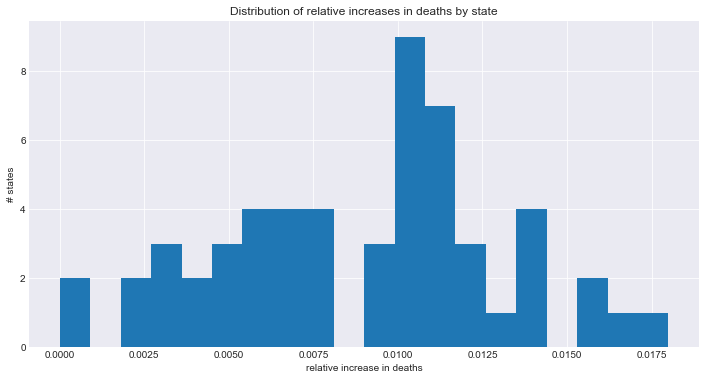

In [170]:
dfp_state_increase_m['frac_increase_deaths'].hist(bins=20)
plt.xlabel('relative increase in deaths')
plt.ylabel('# states')
plt.title('Distribution of relative increases in deaths by state')
plt.show()

In [171]:
# plt.plot(dfp_state_increase_m['frac_increase_deaths'], dfp_state_increase_m['deaths'], 'o', alpha=0.5)
# #plt.xscale('log')
# plt.yscale('log')
# plt.xlabel('relative increase in deaths per day')
# plt.ylabel('# deaths')
# plt.title('Scatter plot of number of deaths (predicted in 1 week) vs relative increase fraction')
# plt.show()

<a id='state_infections_vs_wa'></a>
##### Compare US state infections against Washington

In [172]:
dfp_us_g = dfp_us_g[~(dfp_us_g['date']==datetime.datetime(2020,3,9))]

In [173]:
# _ = days_behind_multi_country(['California', 'New Jersey', 'Florida', 'Louisiana', 'Illinois'], 
#                               'Washington', 
#                               dfp=dfp_us_g, 
#                               country_col='state', 
#                               compare_col='confirmed'
#                              )

<a id='state_infections_vs_ny'></a>
##### Compare US state infections against New York

In [174]:
# _ = days_behind_multi_country(['Washington', 'California', 'New Jersey', 'Florida', 'Louisiana', 'Illinois'], 
#                               'New York', 
#                               dfp=dfp_us_g, 
#                               country_col='state', 
#                               compare_col='confirmed'
#                              )

<a id='mortality_by_us_state'></a>
### Mortality rate by US state

In [175]:
n_states = 10
states = dfp_us_top_states.iloc[:n_states]['state']

#plot_mortality_rate(dfp_us_g, states, upper_lim=0.2, id_col='state', date_min=datetime.datetime(2020,3,2))

##### Relationship between mortality rate and number of cases

In [176]:
#plot_mortality_rate_vs_infections(dfp_us_g, states, upper_lim=0.2, id_col='state', date_min=datetime.datetime(2020,3,1))

<a id='us_state_relative_increases'></a>
### Relative increases per day by state

In [177]:
#find_relative_increase_data_and_plot(dfp_us_g, n_locales=10, col_locale='state', dt=datetime.datetime(2020,4,1))


<a id='us_state_0_new'></a>
# When will each state hit 0 new deaths/confirmed? 

In [178]:
def fit_exp_new(dfp_country, 
            n_days_predict=14, 
            n_days_into_future=[1,7],
            col_locale='country', 
            top_countries=None, 
            n_countries=10, 
            date_most_recent=None,
            is_silent=False,
            fit_cols=['confirmed_new', 'deaths_new']
           ):
    
    # make predictions based on the last 2 weeks of data
    if date_most_recent is None:
        date_most_recent = dfp_country['date'].max()
    date_n_days_ago = date_most_recent - datetime.timedelta(days=n_days_predict-1)
    dfp_country_recent = (dfp_country[dfp_country['date'].between(date_n_days_ago, date_most_recent)].
                          sort_values(by=[col_locale, 'date'])
                         ).copy()

    # clean data for fit (convert to log)
    median_funcs = {}
    log_cols = []
    for col in fit_cols:
        log_col = f'{col}_log'
        dfp_country_recent[log_col] = dfp_country_recent[col].apply(lambda x: np.log10(x) if x > 1 else None)
        median_funcs[log_col] = np.nanmedian
        log_cols.append(log_col)
    dfp_country_recent['unixtime'] = dfp_country_recent['date'].apply(datetime_to_unixtime)
    
    # fill in the missing data with the median
    dfp_country_medians = dfp_country_recent.groupby(col_locale, as_index=False).agg(median_funcs).fillna(0)
    null_countries = list(dfp_country_recent[dfp_country_recent.isnull().any(axis=1)][col_locale].unique())
#     print(f"{col_locale}s with nulls: {','.join(null_countries)}")
#     display(dfp_country_medians.sample(n=5))
#     print(log_cols)
    for col in log_cols:
        for country in null_countries:
            val = dfp_country_medians[dfp_country_medians[col_locale] == country][col].values[0]
            #print(f"country={country}, median value={val:0.5f}")
            dfp_country_recent.loc[(dfp_country_recent[col_locale] == country) & (dfp_country_recent[col].isnull()), col] = val
    
    
    # make predictions to past, then future
    # add in future points
    dfp_country_recent_max_date = dfp_country_recent.groupby([col_locale], as_index=False).agg({'date': np.max})
    dfp_most_recent = dfp_country_recent.merge(dfp_country_recent_max_date, on=[col_locale, 'date'], how='inner').copy()
    list_dfp_recent = [dfp_country_recent]
    for n in n_days_into_future:
        dfp_most_recent_tmp = shift_future(dfp_most_recent, date_most_recent, n, cols_to_be_null_in_future=fit_cols)
        list_dfp_recent.append(dfp_most_recent_tmp)
    dfp_country_recent = pd.concat(list_dfp_recent, axis=0, sort=False)
    
    for col in fit_cols:
        dfp_country_recent, dfp_country_deaths_fit = fit_poly1(dfp_country_recent, 
                                                               col_fit=f'{col}_log', 
                                                               col_pred=f'{col}_pred', 
                                                               col_locale=col_locale, 
                                                               date_most_recent=date_most_recent
                                                              )
    #dfp_country_recent['mortality_rate_pred'] = dfp_country_recent['deaths_pred'] / dfp_country_recent['confirmed_pred']

    # look only at the predictions for top countries
    if top_countries is None:
        top_countries = (dfp_most_recent.
                         sort_values(by='deaths', ascending=0).iloc[:n_countries][col_locale].values)
    dfp_forecasts = dfp_country_recent[(dfp_country_recent['date'] > date_most_recent)
                                       
                                      ].sort_values(by=[col_locale, 'date']).reset_index(drop=True)
    frac_cols = [col for col in dfp_forecasts.columns if 'frac_increase' in col]
    pred_cols = [col for col in dfp_forecasts.columns if '_pred' in col]
    id_cols = ['date', col_locale]
    dfp_forecasts_out = dfp_forecasts[id_cols + pred_cols + frac_cols].copy()
    dfp_forecasts_out['date'] = dfp_forecasts_out['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

    # find the daily fractional increase in cases
    dfp_frac_increase = (dfp_forecasts_out.
                         groupby([col_locale]).
                         agg({x: np.mean for x in frac_cols}))
    dfp_frac_increase.columns = pd.MultiIndex.from_product([dfp_frac_increase.columns, ['']])

    # pivot so each date of prediction has its own column
    dfp_forecasts_print = dfp_forecasts_out.pivot(index=col_locale, 
                                                  columns='date', 
                                                  values=pred_cols  #'mortality_rate_pred'
                                                 ).sort_values(by=(pred_cols[0], dfp_forecasts_out['date'].min()), ascending=0)
    dfp_forecasts_print = dfp_forecasts_print.merge(dfp_frac_increase, on=col_locale, how='inner')
    if not is_silent:
        display(dfp_forecasts_print[dfp_forecasts_print.index.isin(top_countries)])
    return dfp_country_recent, dfp_forecasts_out


def plot_forecasts_new(dfp_country_recent, 
                        n_countries=10, 
                        n_columns=2, 
                        figsize=(12,24), 
                        date_min=datetime.datetime(2020, 2, 1),
                        col_locale='country',
                       top_countries=None,
                       cols_to_pred=['confirmed_new', 'deaths_new'],
                       cols_deaths='deaths_new',
                       frac_increase_col='frac_increase_deaths',
                  ):
    # subset the top countries
    death_cols = [col for col in cols_to_pred if 'deaths' in col]
    dfp_non_pred = dfp_country_recent.dropna(subset=[death_cols[0]])
    dt_max = dfp_non_pred['date'].max()
    
    if top_countries is None:
        dfp_top_countries = (dfp_non_pred[dfp_non_pred['date'] == dt_max].
                             sort_values(by=death_cols[0], ascending=0).
                             iloc[:n_countries]
                            )
        top_countries = (dfp_top_countries.
                         iloc[:n_countries][col_locale].values
                        )
    else:
        n_countries = len(top_countries)
        
    dfp_country_recent = dfp_country_recent[dfp_country_recent[col_locale].isin(top_countries)]

    # plot the top countries
    i = 1
    n_rows = int(np.ceil(n_countries / n_columns))
    plt.figure(figsize=figsize)
    
    y_max = 1
    pred_cols = [x + '_pred' for x in cols_to_pred]
    for col in cols_to_pred:
        y_max = max(dfp_country_recent[col].max(), y_max)
    y_min = 1

    for country in top_countries:
        dfp_plot = dfp_country_recent[(dfp_country_recent[col_locale] == country) &
                               (dfp_country_recent['date'] >= date_min)
                              ].sort_values(by='date')
        
        # find total deaths
        dfp_plot_calcs = dfp_plot.dropna(subset={cols_deaths})
        dfp_plot_latest = dfp_plot_calcs[dfp_plot_calcs['date'] == dfp_plot_calcs['date'].max()]
        x = 1 + dfp_plot_calcs[frac_increase_col].mean()
        n_days = (dfp_country_recent['date'].max() - dfp_plot_calcs['date'].max()).days
        multiplier = (x**n_days - 1) / (x - 1)
        curr_deaths_new = dfp_plot_latest[f'{cols_deaths}_pred'].values[0]
        curr_deaths_total = dfp_plot_latest['deaths'].values[0]
        n_deaths_pred = curr_deaths_new * multiplier + curr_deaths_total
        
        
        plt.subplot(n_rows, n_columns, i)
        for key in cols_to_pred:
            p = plt.plot(dfp_plot['date'], dfp_plot[key], alpha=0.5, linewidth=2, label=key)
            pred_col = f'{key}_pred'
            plt.plot(dfp_plot['date'], dfp_plot[pred_col], linestyle='--', linewidth=2, alpha=0.5, color=p[0].get_color(), label=pred_col)
        plt.legend(loc='best')
        plt.ylabel('num cases')
        plt.title(f'{col_locale}: {country}, pred_tot_deaths = {n_deaths_pred:0.0f}, curr_deaths = {curr_deaths_total:0.0f}, x={x:0.3f}')
        plt.yscale('log')
        plt.ylim([y_min, y_max])
        plt.xticks(rotation=90)

        i += 1
    plt.tight_layout()
    plt.show()
    return None
                       
                       
def save_forecast_new(dfp_forecasts_out, dfp_country_recent, col_locale='state', n_days_training=14):
    date_most_recent = dfp_country_recent.dropna(subset=['deaths'])['date'].max()
    dfp_forecasts_out['date_of_forecast'] = date_most_recent
    save_name = f"new_cases_covid-19_{col_locale}_forecast_from_{date_most_recent.strftime('%Y-%m-%d')}_n_days_training={n_days_training}.csv"
    save_path = os.path.join('predictions', save_name)
    dfp_forecasts_out.to_csv(save_path, index=False)
    print(f'saved forecast to {save_path}')
    return None

In [179]:
n_days_training = 21
dfp_us_g['deaths_new_smooth'] = dfp_us_g.groupby(['country', 'state'], as_index=False)['deaths_new'].rolling(7).mean().reset_index(0,drop=True)
dfp_us_g['confirmed_new_smooth'] = dfp_us_g.groupby(['country', 'state'], as_index=False)['confirmed_new'].rolling(7).mean().reset_index(0,drop=True)
dfp_us_recent_1, dfp_forecasts_us_out_1 = fit_exp_new(dfp_us_g, 
                                                    n_days_predict=n_days_training,
                                                    n_days_into_future=[1,7,2*7,4*7,8*7,12*7,16*7,20*7,24*7,32*7], 
                                                    col_locale='state', 
                                                    top_countries=None,
                                                      fit_cols=['confirmed_new_smooth', 'deaths_new_smooth'],
                                                   )

confirmed_new_smooth_pred                                   \
date                         2020-12-24 2020-12-30 2021-01-06 2021-01-20   
state                                                                      
California                        52078      69996      98830     197024   
Texas                             16098      16769      17588      19347   
Florida                           11345      12171      13211      15564   
New York                          11131      11950      12983      15324   
Pennsylvania                      10003      10313      10687      11475   
Georgia                            7251       8408       9993      14114   
Illinois                           6946       6253       5531       4328   
Massachusetts                      5031       5231       5474       5994   
New Jersey                         4543       4481       4411       4273   
Michigan                           3617       2897       2235       1331   

                                                                      \
date          2021-02-17 2021-03-17 2021-04-14 2021-05-12 2021-06-09   
state                                                                  
California        783037    3112033   12368186   49155014  195357292   
Texas              23410      28326      34275      41472      50182   
Florida            21605      29990      41630      57786      80213   
New York           21348      29740      41432      57719      80409   
Pennsylvania       13231      15255      17589      20280      23383   
Georgia            28160      56182     112088     223626     446154   
Illinois            2650       1623        994        608        372   
Massachusetts       7187       8619      10335      12392      14860   
New Jersey          4010       3763       3531       3313       3109   
Michigan             472        167         59         21          7   

                          deaths_new_smooth_pred                        \
date           2021-08-04             2020-12-24 2020-12-30 2021-01-06   
state                                                                    
California     3085696628                    296        412        607   
Texas               73472                    213        234        260   
Florida            154555                    101        103        105   
New York           156054                    144        191        267   
Pennsylvania        31085                    223        264        321   
Georgia           1775857                     40         37         34   
Illinois              139                    158        154        150   
Massachusetts       21367                     56         62         69   
New Jersey           2738                     72         83         96   
Michigan                0                    125        127        128   

                                                                      \
date          2021-01-20 2021-02-17 2021-03-17 2021-04-14 2021-05-12   
state                                                                  
California          1314       6165      28909     135552     635587   
Texas                322        494        759       1164       1786   
Florida              109        118        128        139        150   
New York             520       1973       7476      28322     107292   
Pennsylvania         475       1038       2267       4954      10822   
Georgia               30         22         16         12          9   
Illinois             141        126        112         99         88   
Massachusetts         86        135        211        329        514   
New Jersey           130        237        434        792       1446   
Michigan             132        139        146        154        163   

                                    frac_increase_confirmed  \
date          2021-06-09 2021-08-04                           
state                                                         

In [180]:
#dfp_us_recent_1[dfp_us_recent_1.date == '2020-05-29'].sort_values(by='deaths_new_pred', ascending=0).reset_index(drop=True)

##### Fraction of increase in confirmed cases

In [181]:
# plot_forecasts_new(
#     dfp_us_recent_1, 
#     col_locale='state', 
#     top_countries=['Washington', 'California', 'Ohio', 'Florida', 'Georgia', 'Illinois', 'New York', 'New Jersey', 'Minnesota', 'Kentucky', 'Wisconsin', 'Arizona', 'South Carolina', 'North Carolina', 'Texas'],
#     cols_to_pred=['confirmed_new_smooth', 'deaths_new_smooth'],
#     cols_deaths='deaths_new_smooth',
#     frac_increase_col='frac_increase_confirmed'
# )

##### Fraction increase in deaths_new

In [182]:
# plot_forecasts_new(
#     dfp_us_recent_1, 
#     col_locale='state', 
#     top_countries=['Washington', 'California', 'Ohio', 'Florida', 'Georgia', 'Illinois', 'New York', 'New Jersey', 'Minnesota', 'Kentucky', 'Wisconsin', 'Arizona', 'South Carolina', 'North Carolina', 'Texas'],
#     cols_to_pred=['confirmed_new_smooth', 'deaths_new_smooth'],
#     cols_deaths='deaths_new_smooth',
#     frac_increase_col='frac_increase_deaths'
# )

In [183]:
save_forecast_new(dfp_forecasts_us_out_1, dfp_us_recent_1, 'state', n_days_training=n_days_training)

saved forecast to predictions/new_cases_covid-19_state_forecast_from_2020-12-23_n_days_training=21.csv


<a id='us_state_smoothed_trend'></a>
### Plot trends

In [184]:
dfp_us_g_new_confirmed = dfp_us_g[dfp_us_g['date'] > datetime.datetime(2020,4,1)].groupby('state', as_index=False).agg({'confirmed_new': np.sum})
states_minimum_thresh = dfp_us_g_new_confirmed[(dfp_us_g_new_confirmed['confirmed_new'] > 100)].state

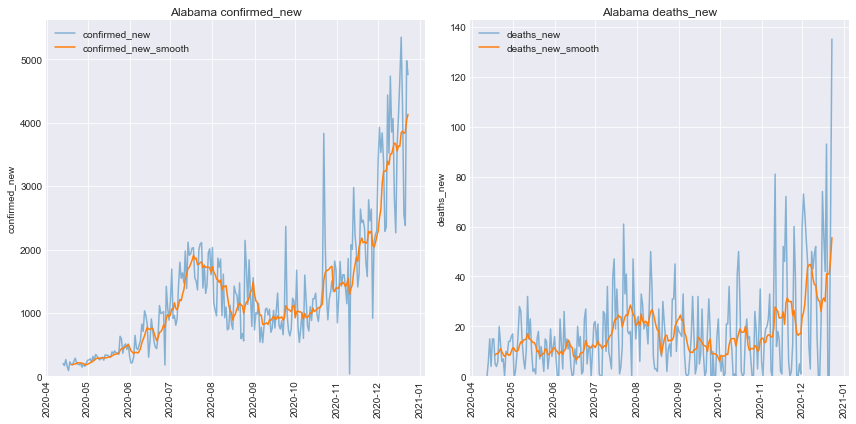

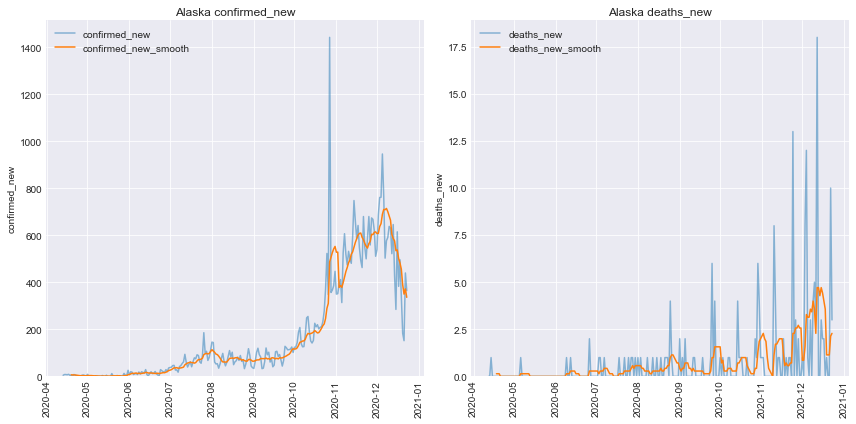

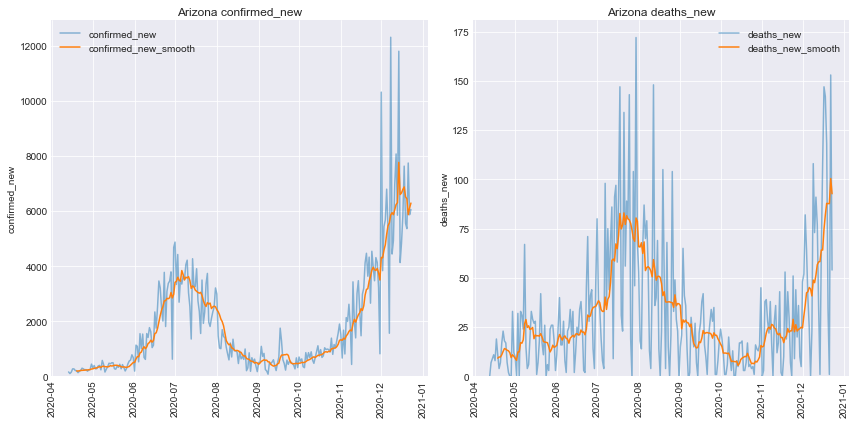

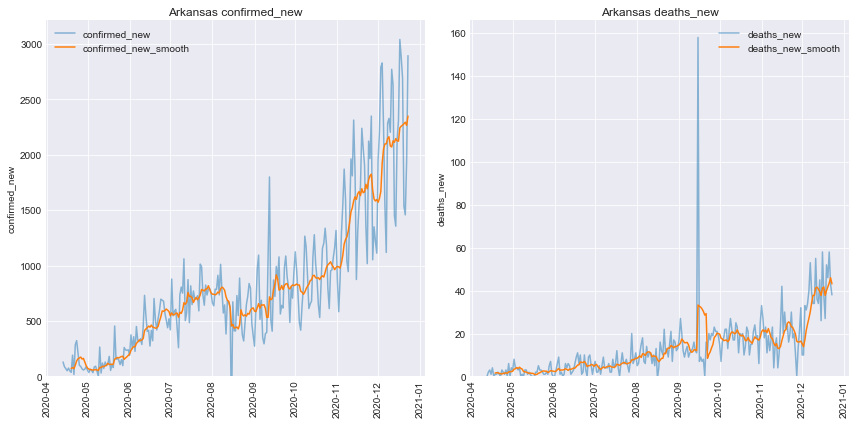

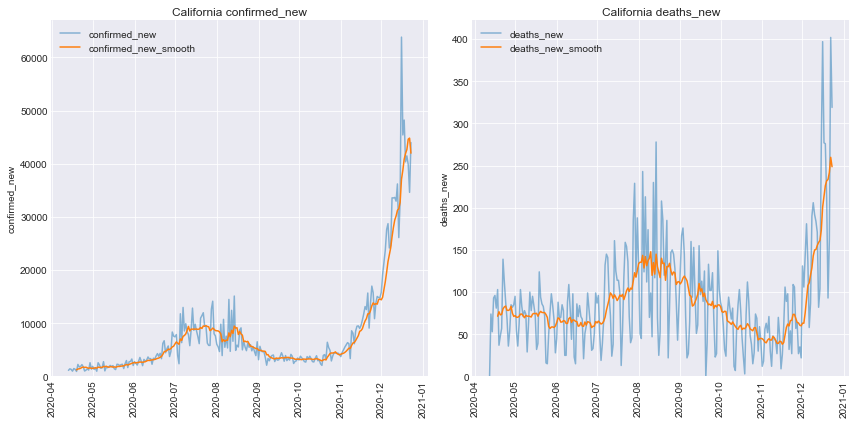

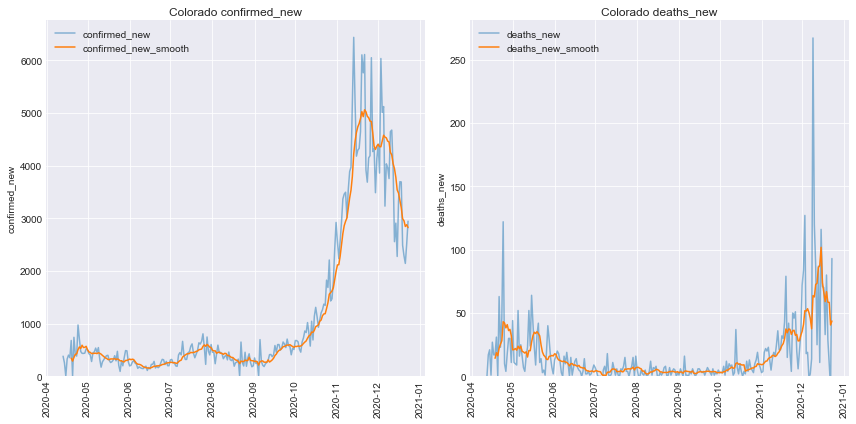

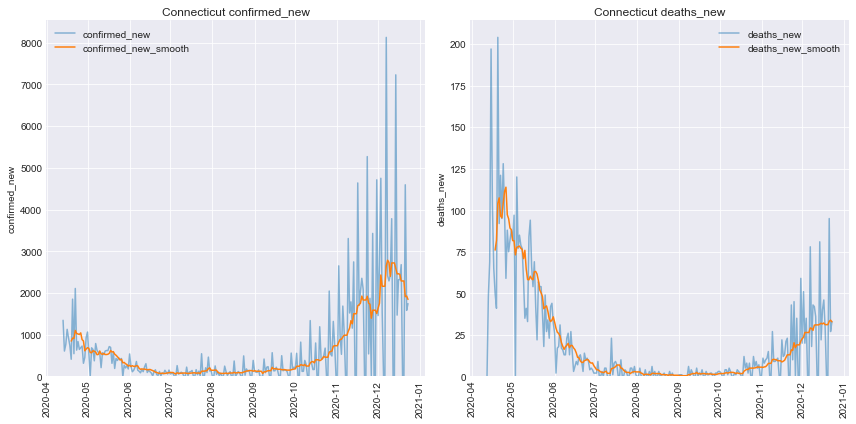

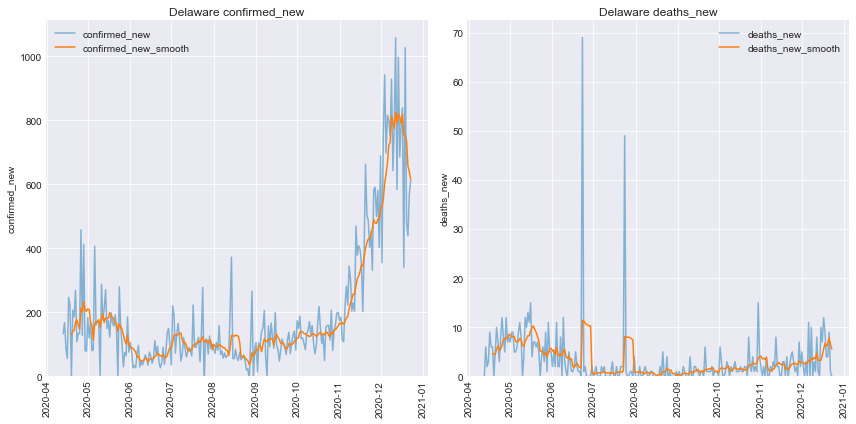

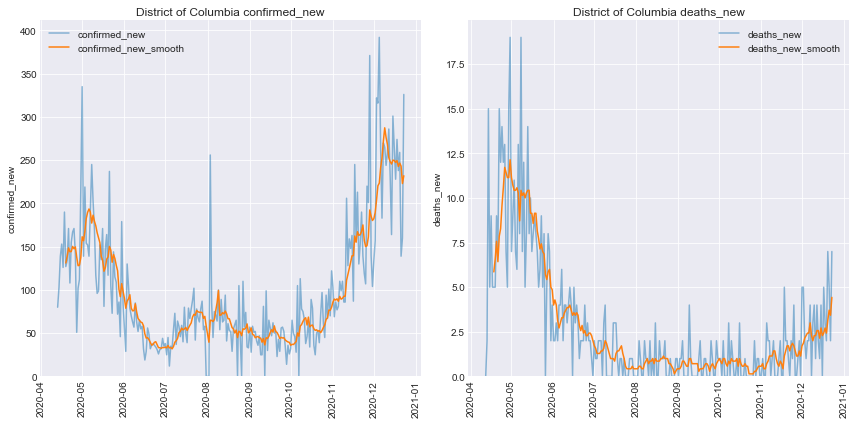

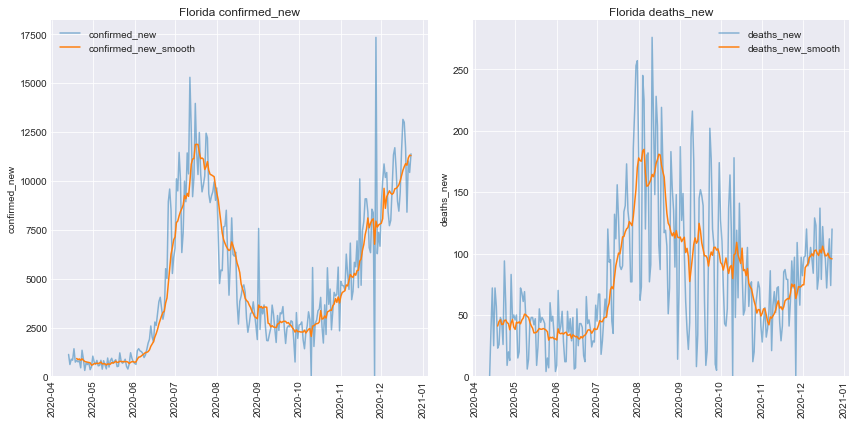

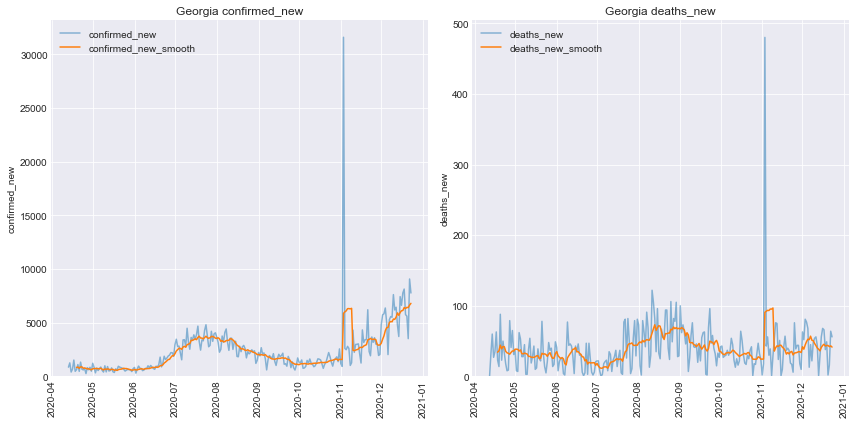

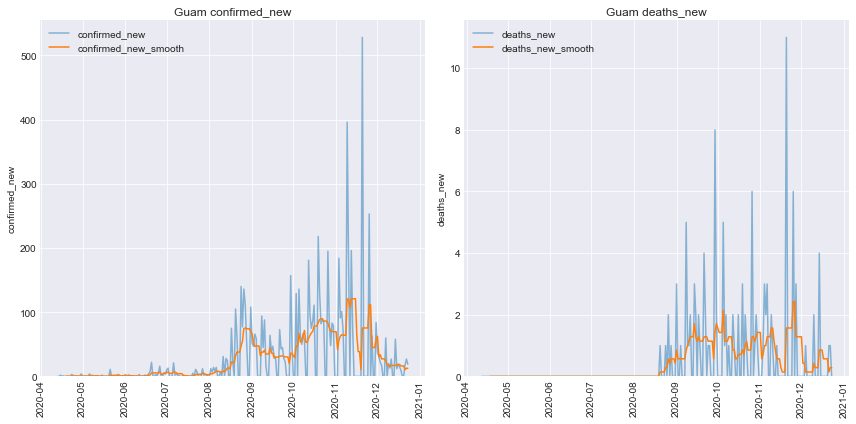

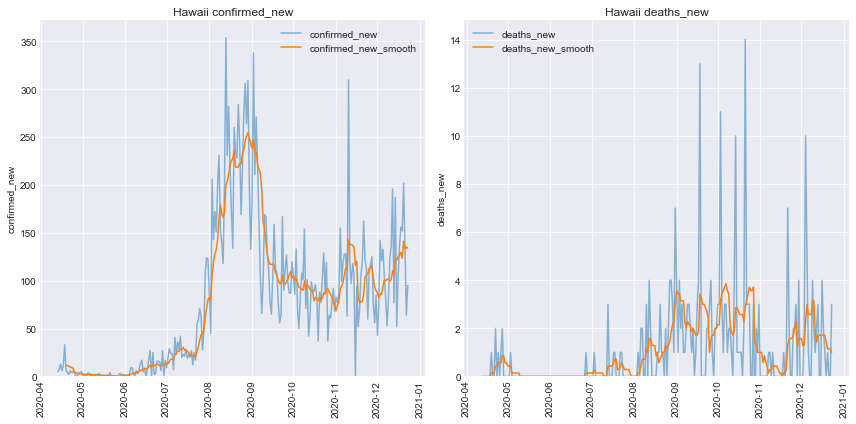

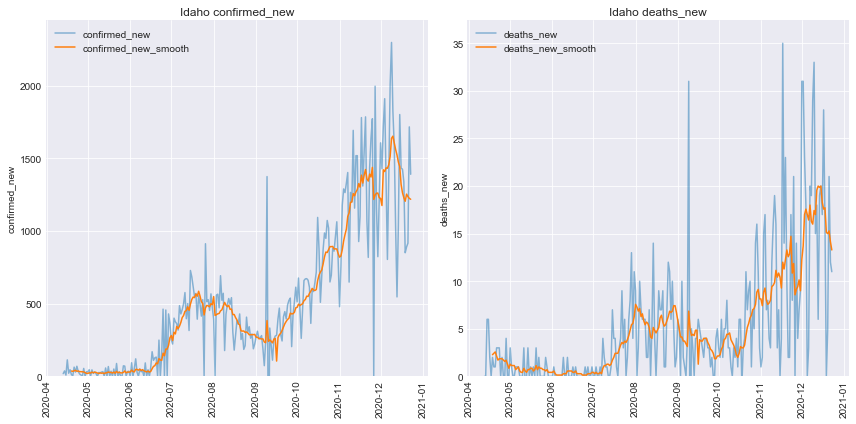

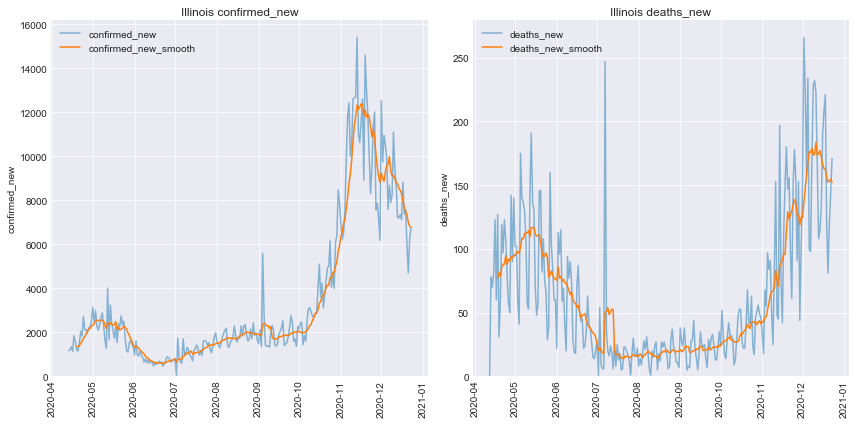

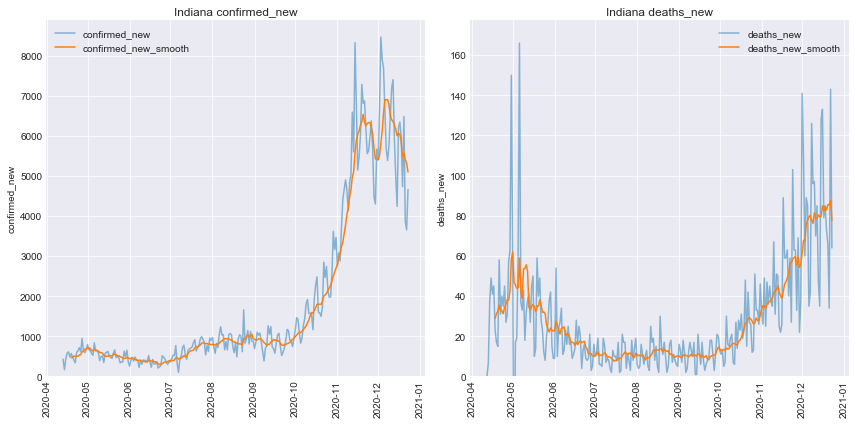

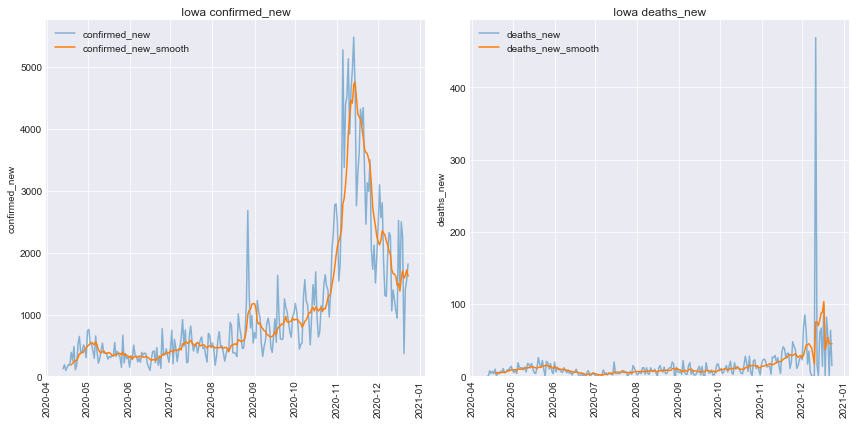

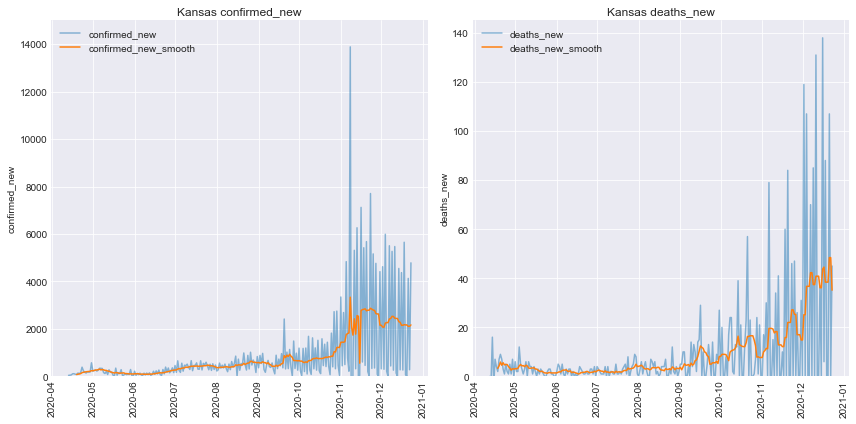

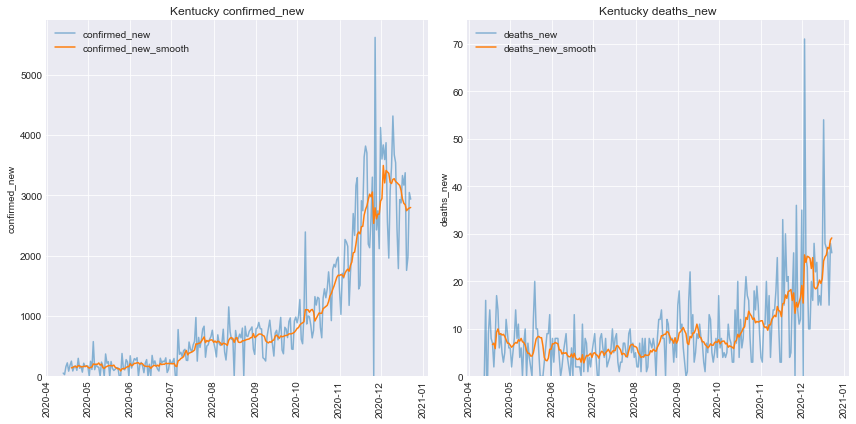

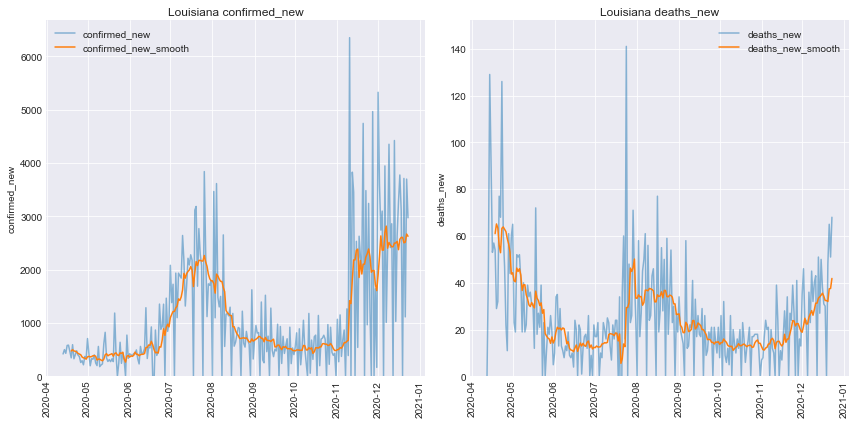

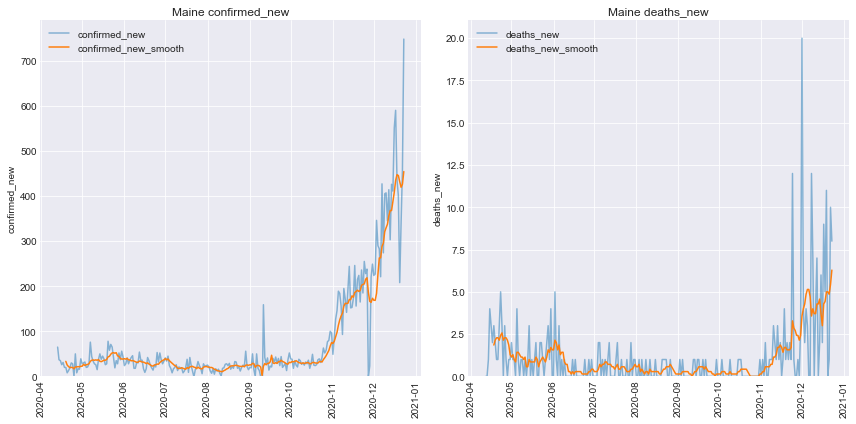

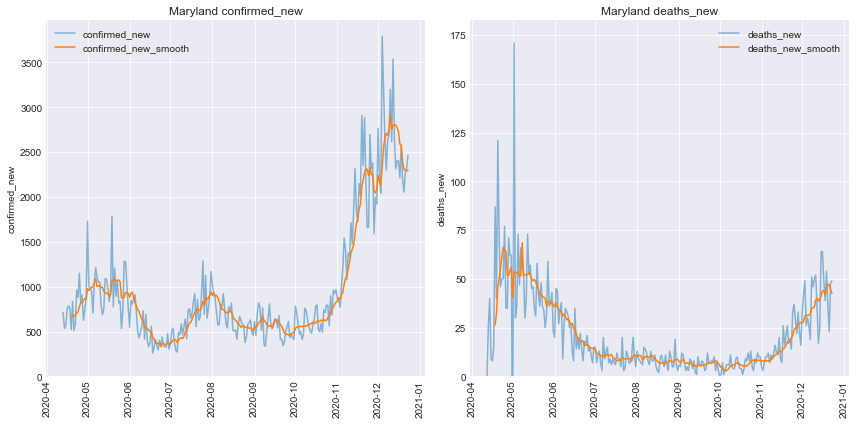

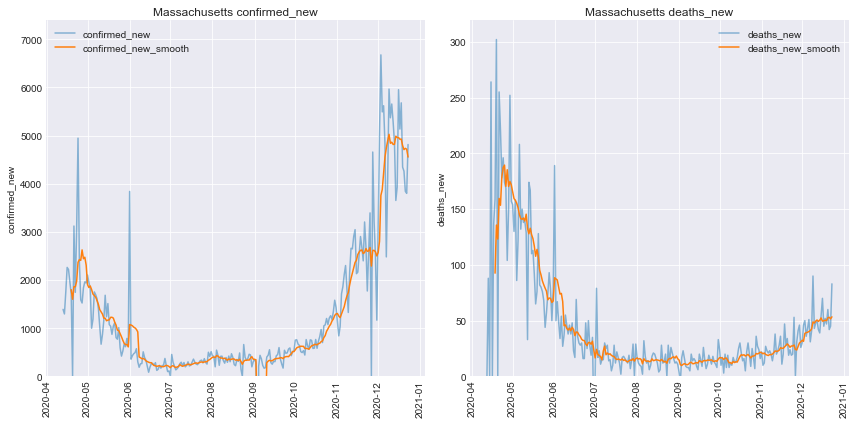

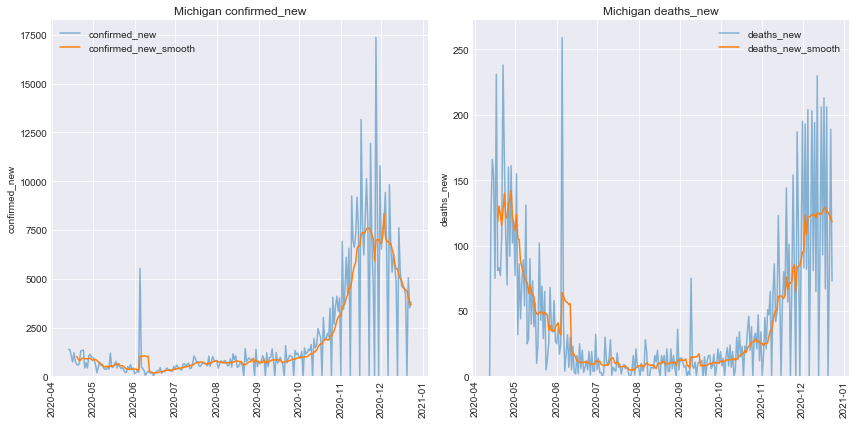

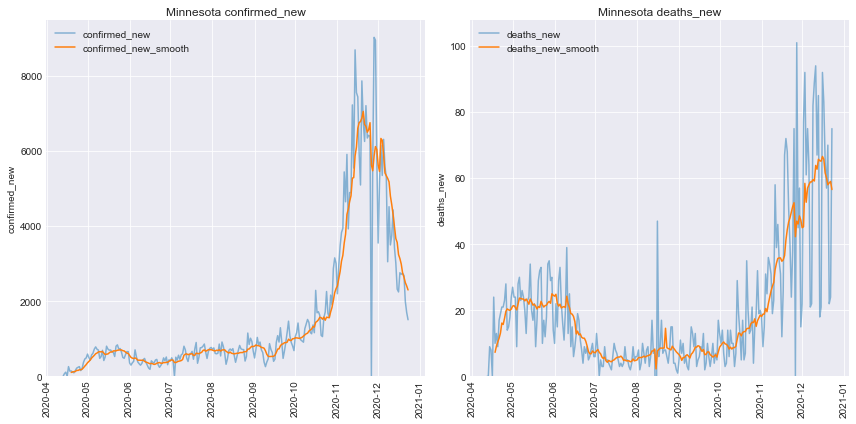

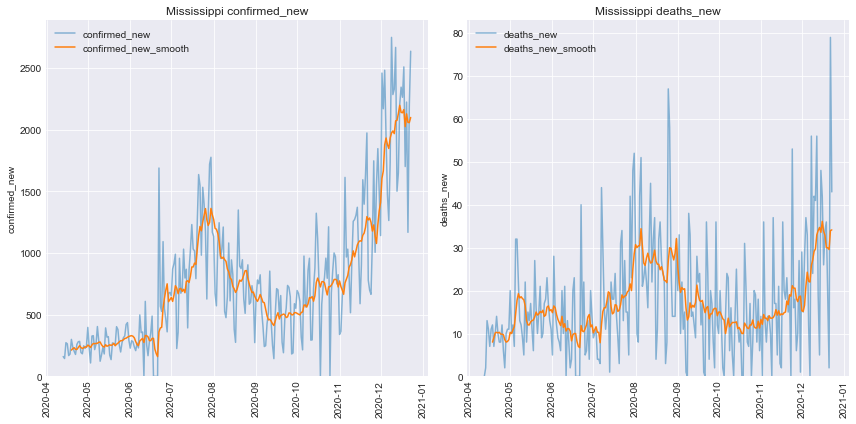

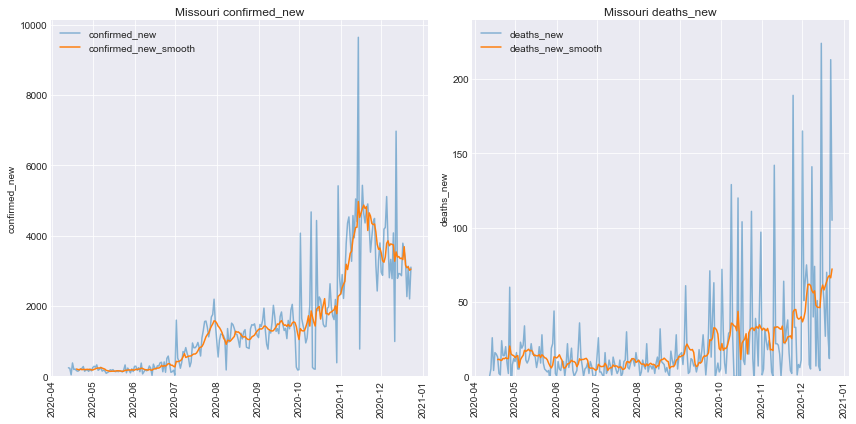

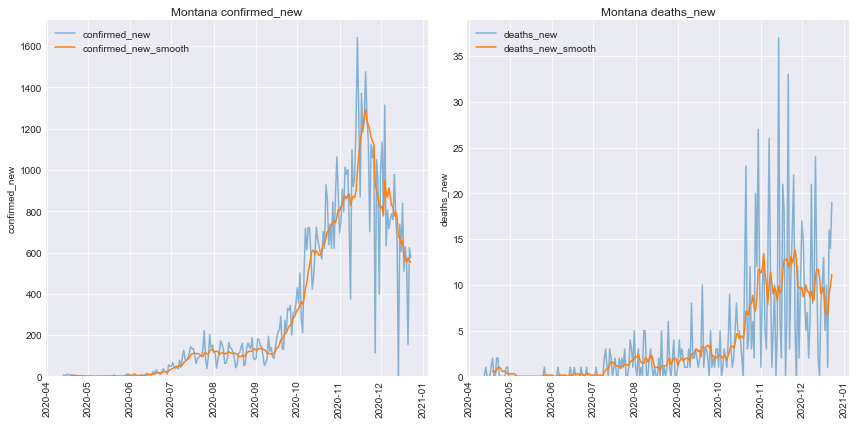

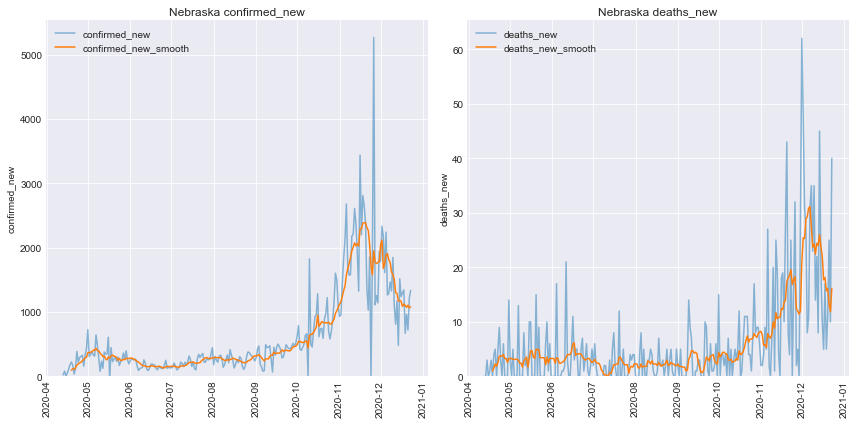

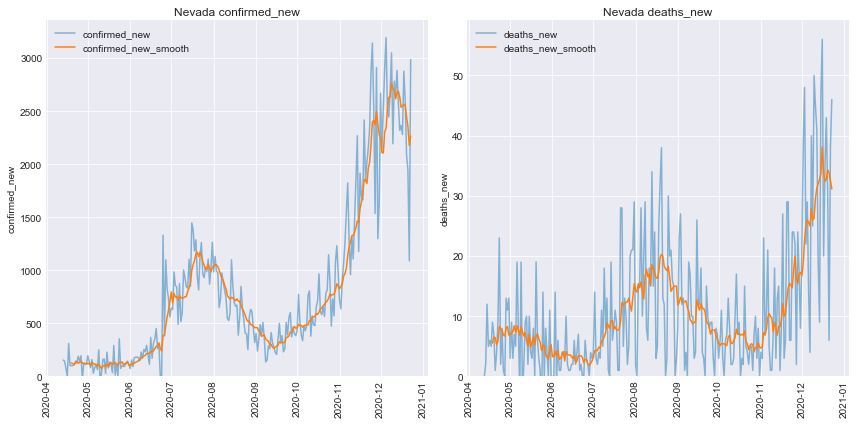

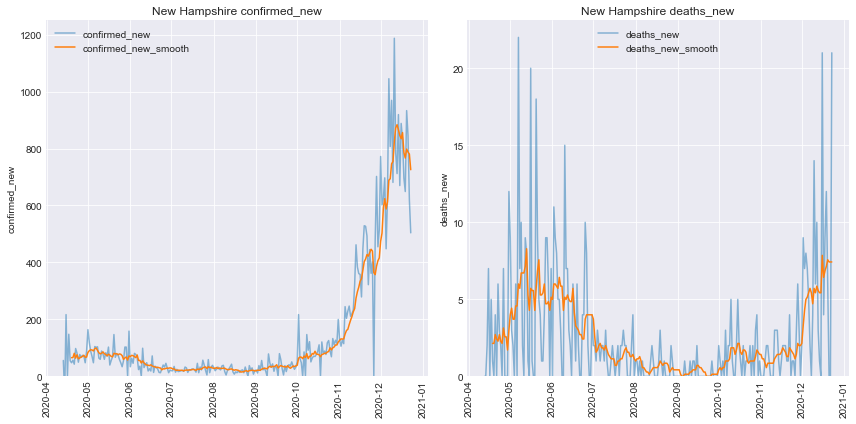

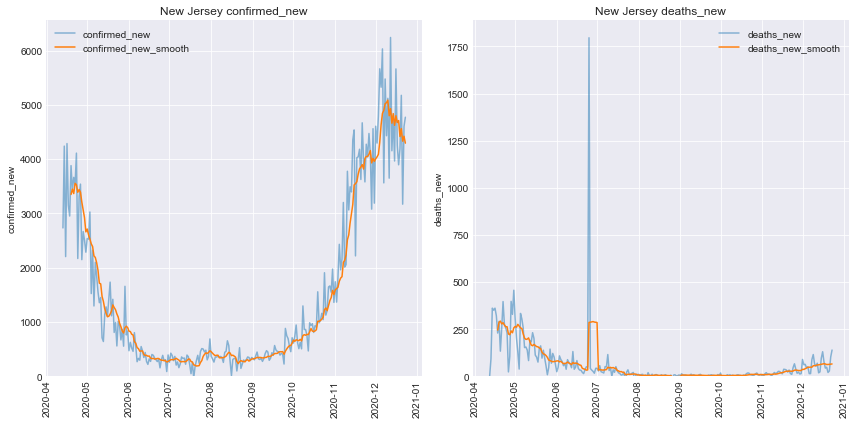

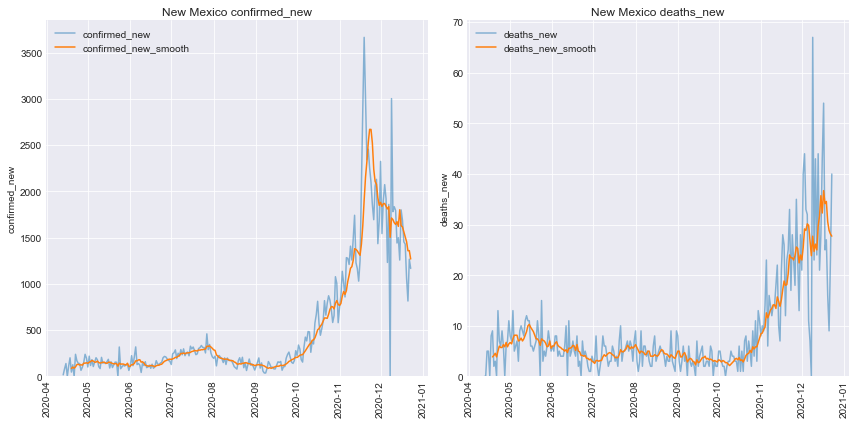

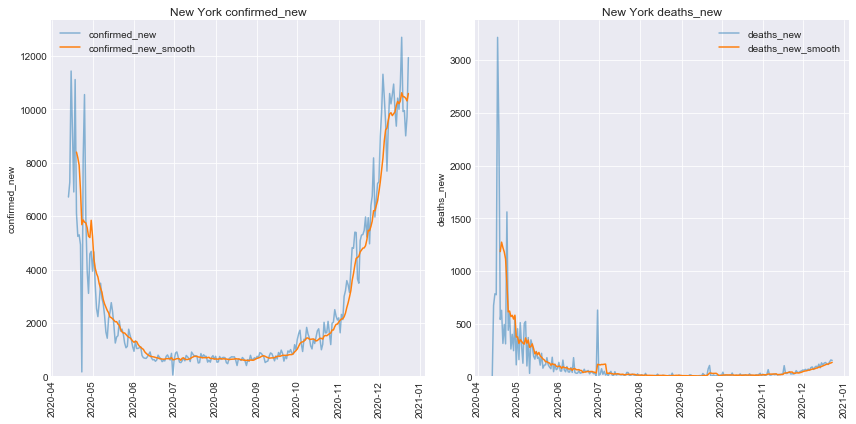

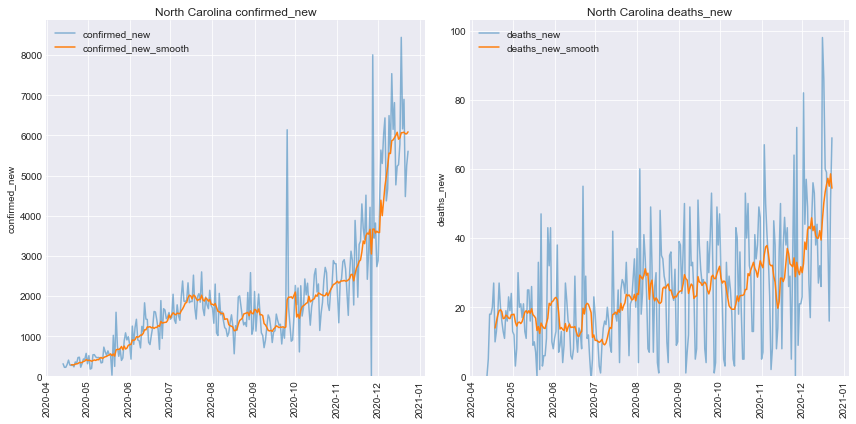

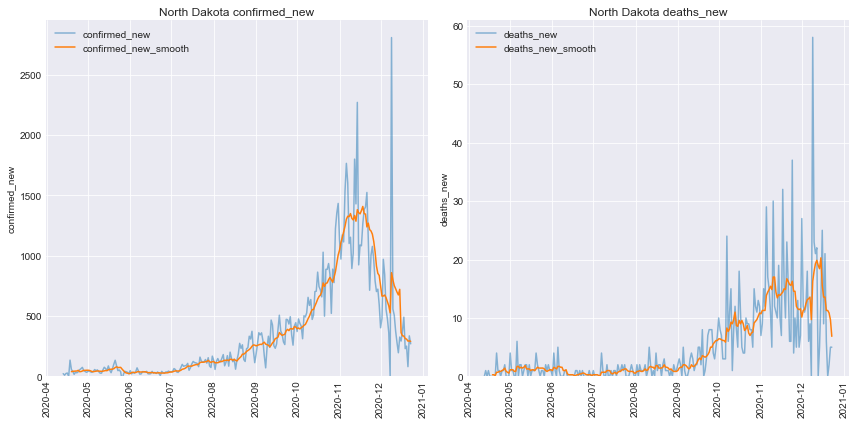

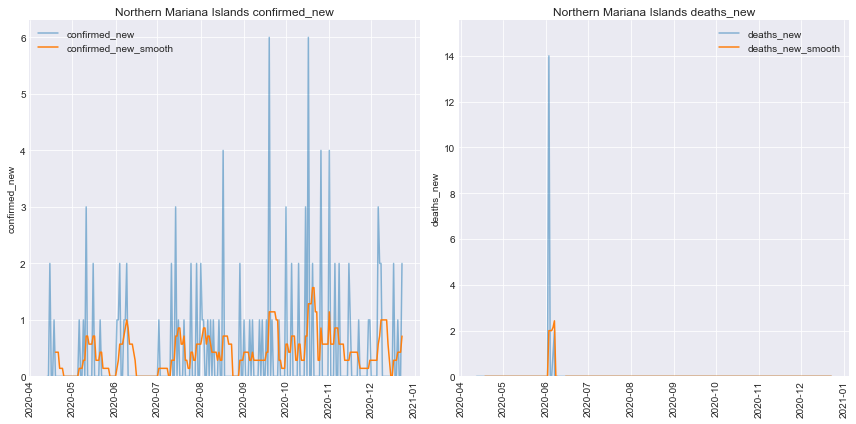

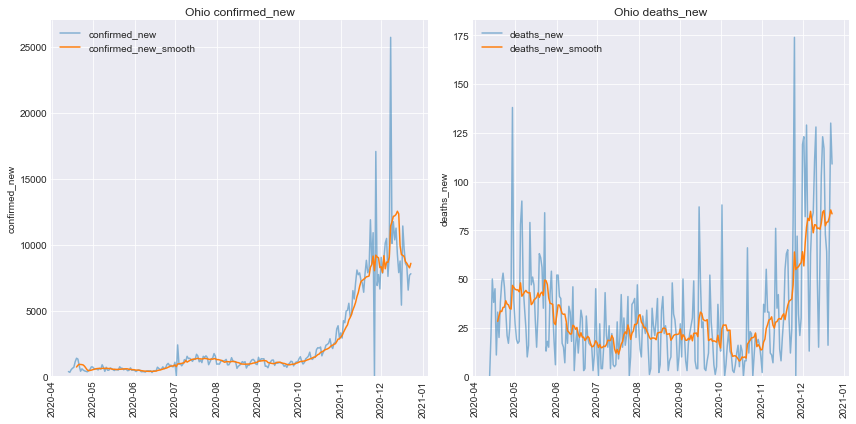

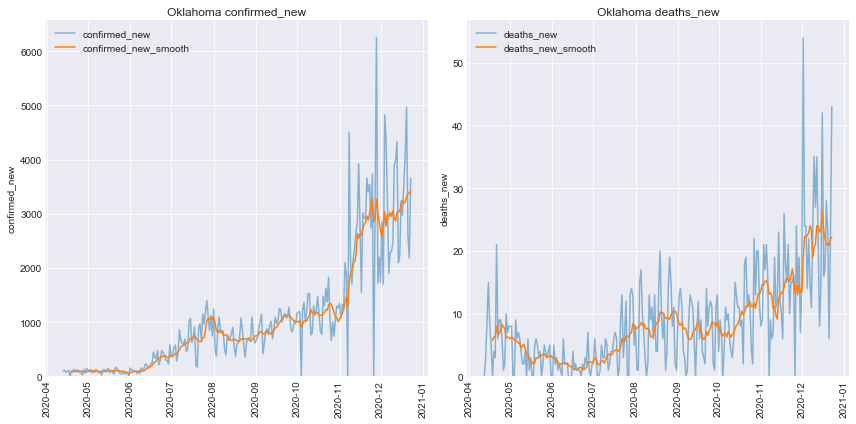

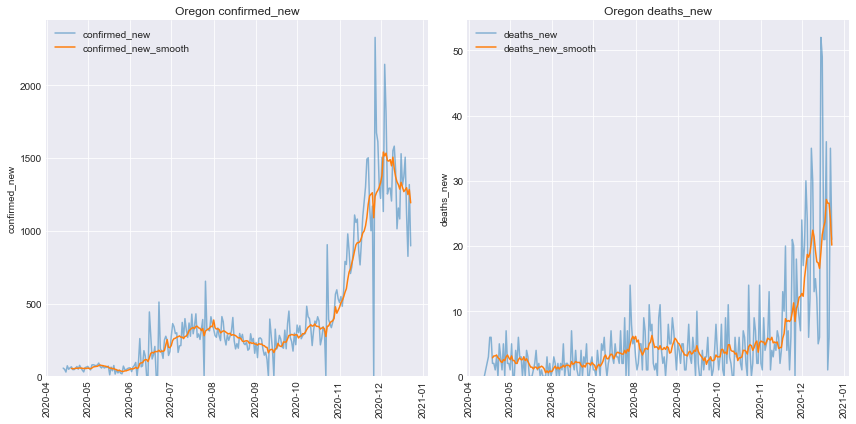

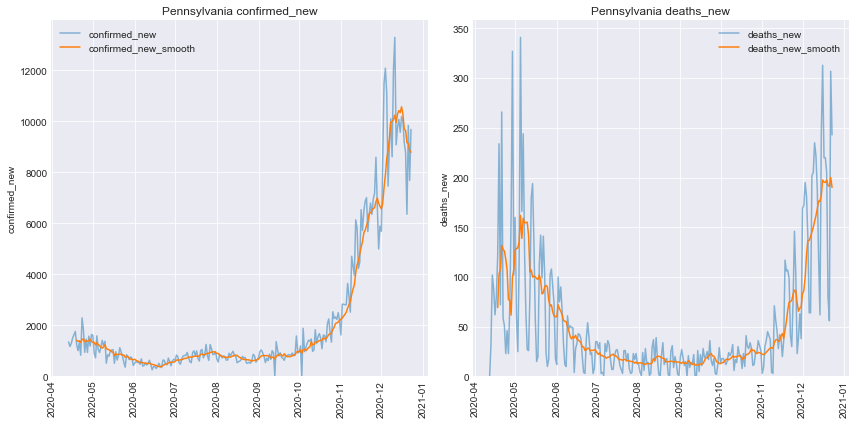

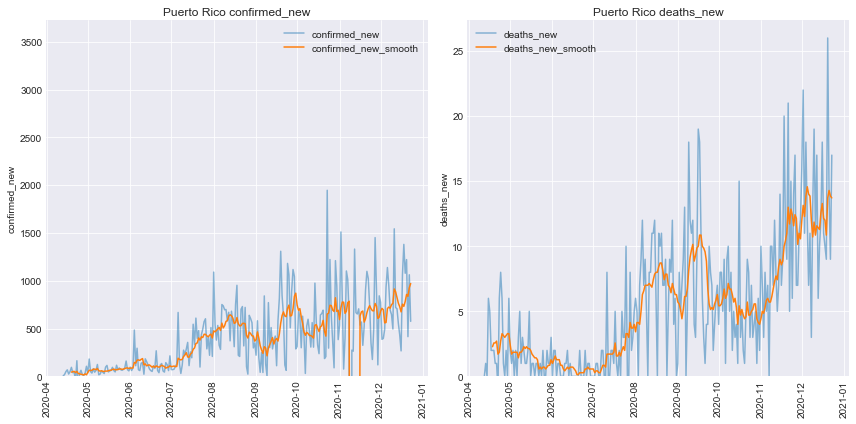

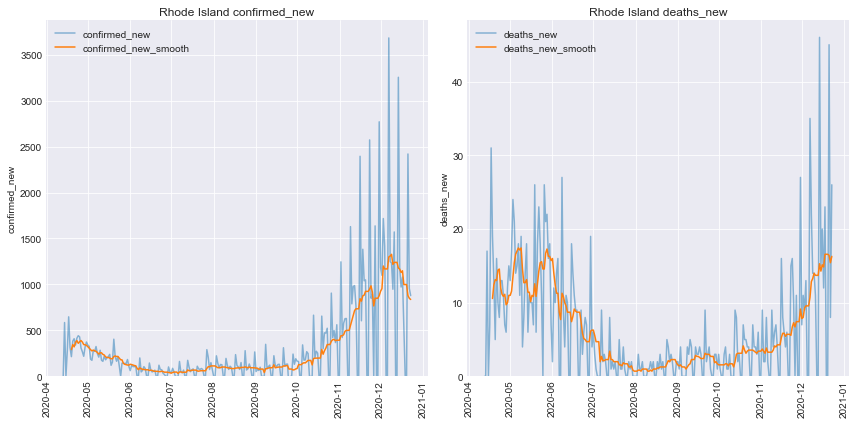

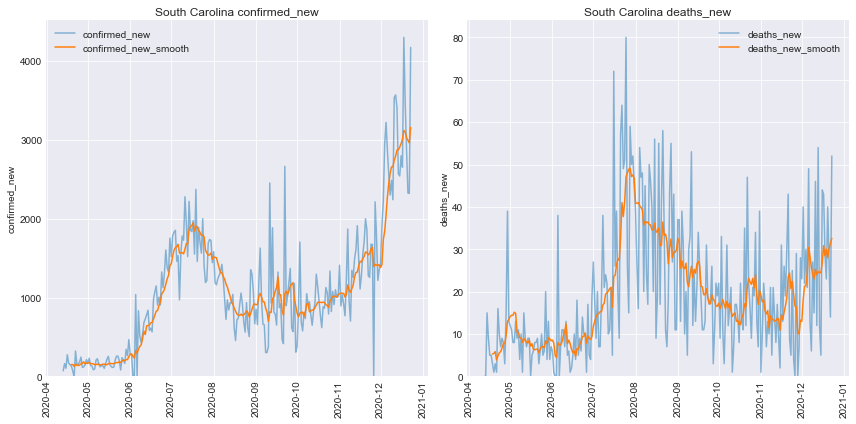

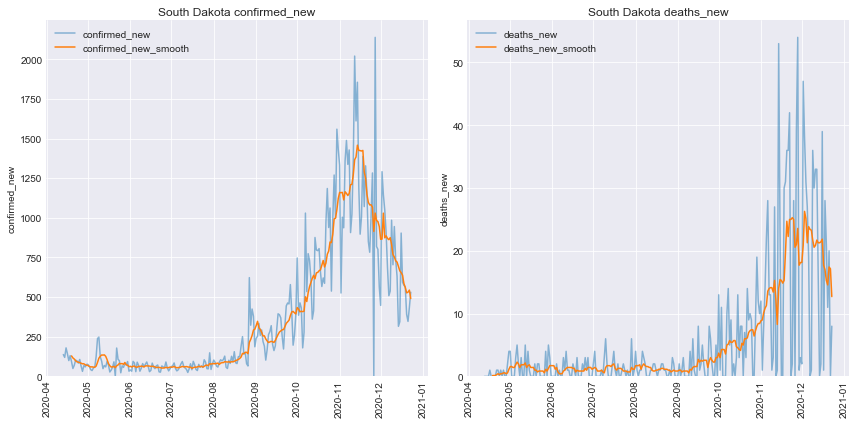

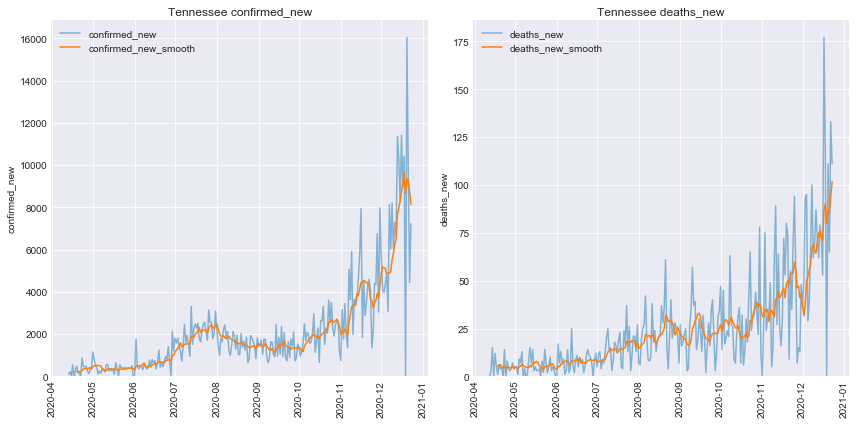

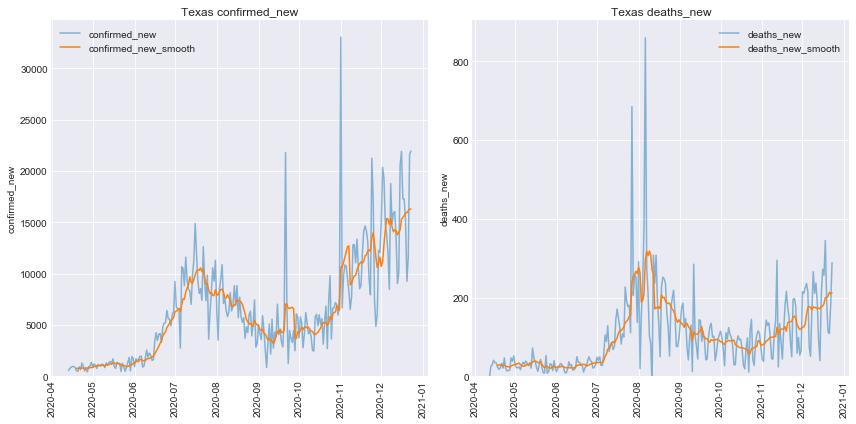

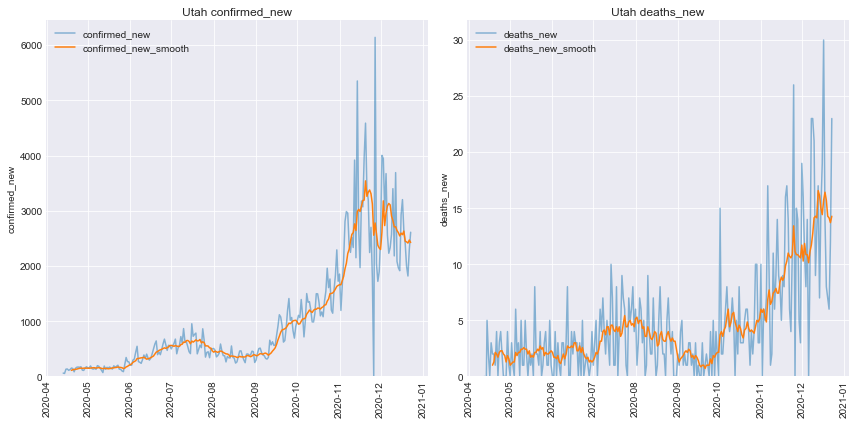

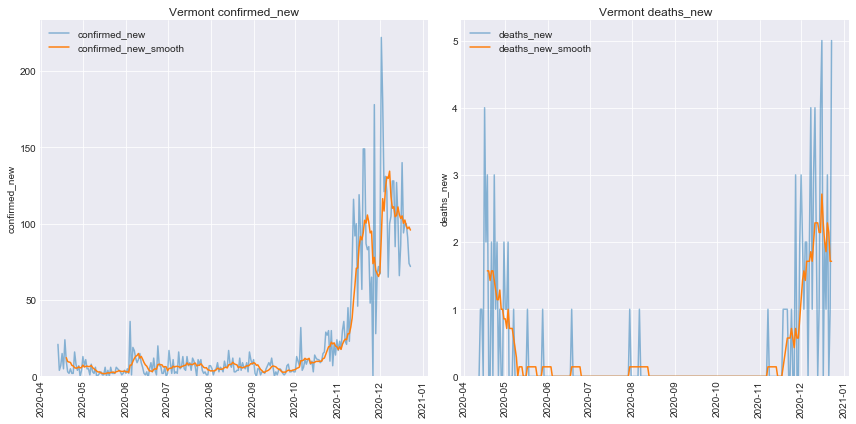

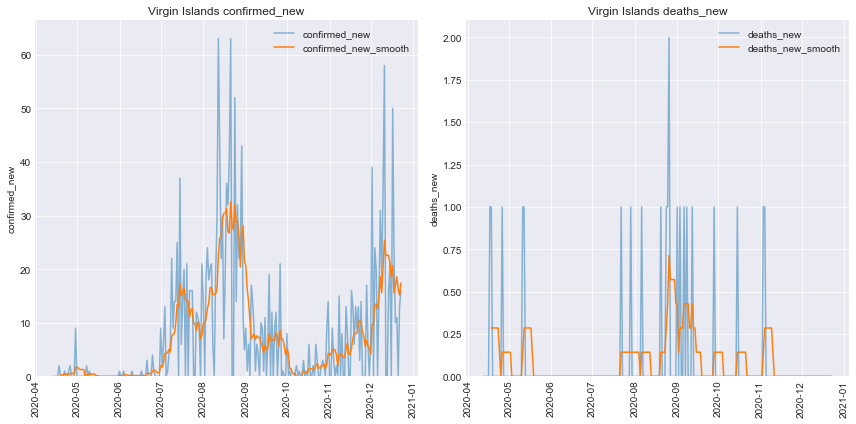

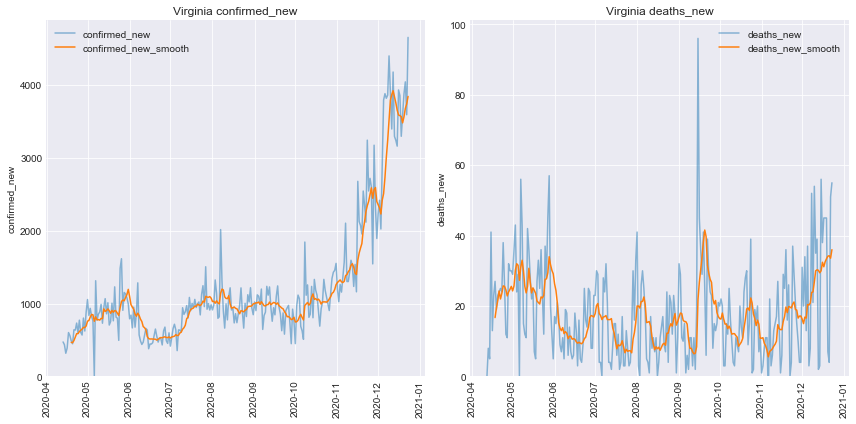

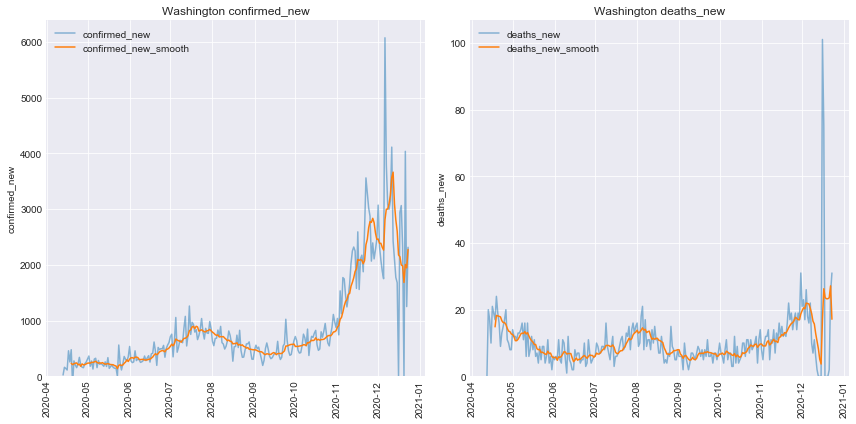

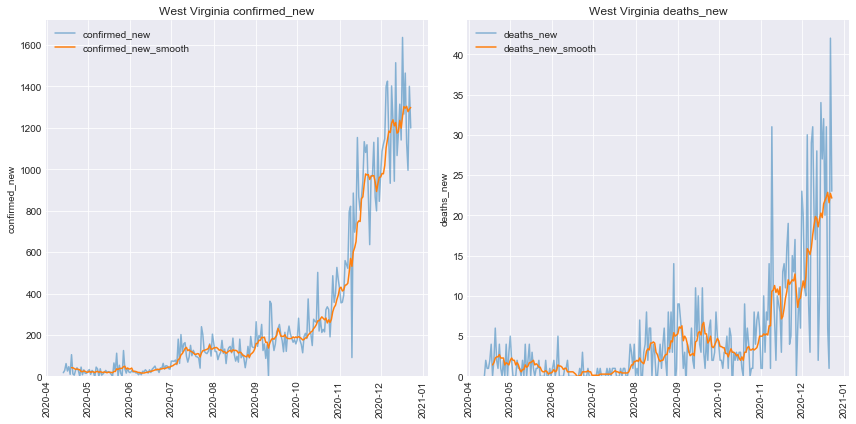

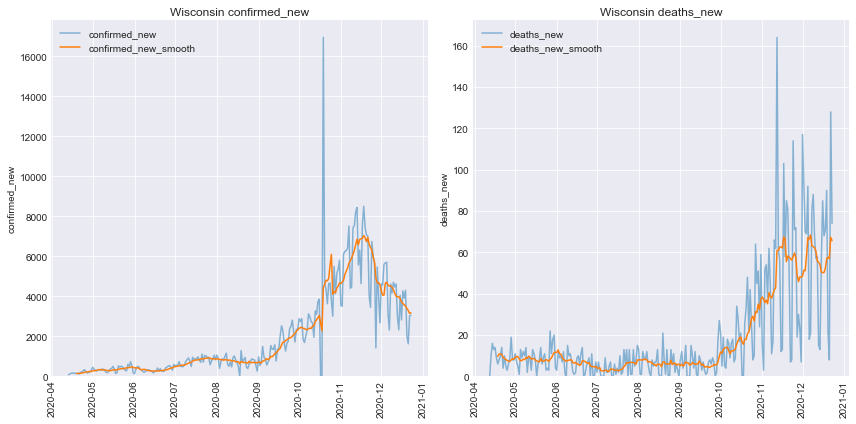

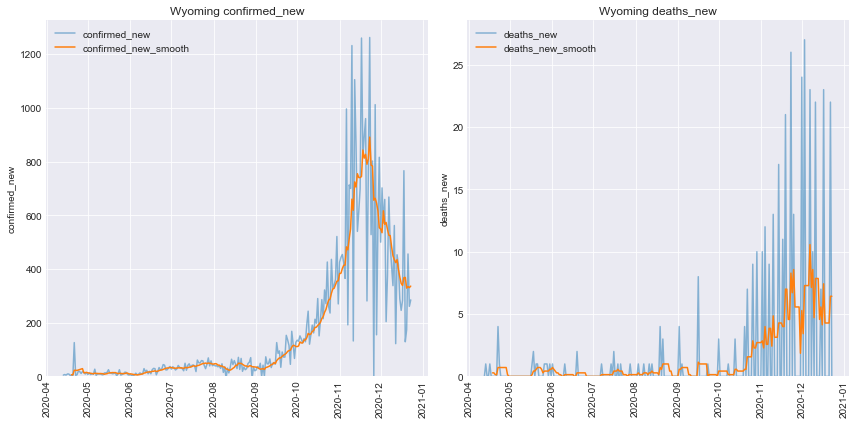

In [185]:


#plot_smoothed_trend(dfp_us_g, ['Washington', 'Ohio', 'California', 'Texas', 'Minnesota', 'Wisconsin'], cols_plot=['confirmed_new', 'deaths_new'])

plot_smoothed_trend(dfp_us_g, states_minimum_thresh, cols_plot=['confirmed_new', 'deaths_new'])

### All states sorted by new deaths DESC

In [186]:
dfp_us_frac_new_increase = (dfp_us_recent_1[['state', 'frac_increase_deaths', 'frac_increase_confirmed']].
                             drop_duplicates().
                             sort_values(by='frac_increase_deaths', ascending=0).
                             reset_index(drop=True)
                            )
dfp_us_frac_new_increase

state  frac_increase_deaths  frac_increase_confirmed
0                 California              0.056737                 0.050515
1                    Arizona              0.050816                 0.013882
2                   Delaware              0.050637                 0.004001
3                   New York              0.048717                 0.011911
4                   Virginia              0.036621                 0.020186
5                  Tennessee              0.036396                 0.039671
6                   Arkansas              0.034910                 0.009583
7               Rhode Island              0.030103                -0.017700
8              West Virginia              0.029545                 0.010586
9               Pennsylvania              0.028300                 0.005097
10               Mississippi              0.026514                 0.008365
11                 Louisiana              0.025654                 0.001365
12             New Hampshire              0.024931                 0.013584
13                  Maryland              0.022307                -0.003408
14      District of Columbia              0.021848                 0.000635
15                New Jersey              0.021719                -0.002267
16            North Carolina              0.019332                 0.018055
17                    Nevada              0.019115                -0.001019
18                      Iowa              0.019083                -0.021736
19                    Oregon              0.018857                -0.012054
20                      Utah              0.017514                -0.013054
21             Massachusetts              0.016025                 0.006506
22                     Texas              0.015398                 0.006831
23            South Carolina              0.014457                 0.024474
24                  Missouri              0.012205                -0.008617
25                   Vermont              0.011802                -0.013300
26               Connecticut              0.011606                -0.008856
27                    Kansas              0.010601                -0.004566
28                     Maine              0.006913                 0.038135
29                New Mexico              0.006756                -0.015272
30                   Indiana              0.006663                -0.011167
31                  Kentucky              0.006477                -0.011332
32                  Colorado              0.005130                -0.027405
33                      Ohio              0.004226                -0.005779
34                   Alabama              0.003804                 0.015458
35                   Florida              0.002869                 0.011781
36                Washington              0.002736                -0.018846
37                 Minnesota              0.002719                -0.052239
38                  Michigan              0.001878                -0.036341
39               Puerto Rico              0.000576                 0.015711
40            American Samoa              0.000000                 0.000000
41          Diamond Princess              0.000000                 0.000000
42  Northern Mariana Islands              0.000000                 0.000000
43            Virgin Islands              0.000000                 0.015135
44                      Guam              0.000000                -0.037971
45            Grand Princess              0.000000                 0.000000
46                  Oklahoma             -0.000895                 0.008680
47                 Wisconsin             -0.003222                -0.019280
48                   Montana             -0.004015                -0.027899
49                  Illinois             -0.004150                -0.017363
50                     Idaho             -0.007329                -0.011710
51                   Georgia             -0.010528                 0.02

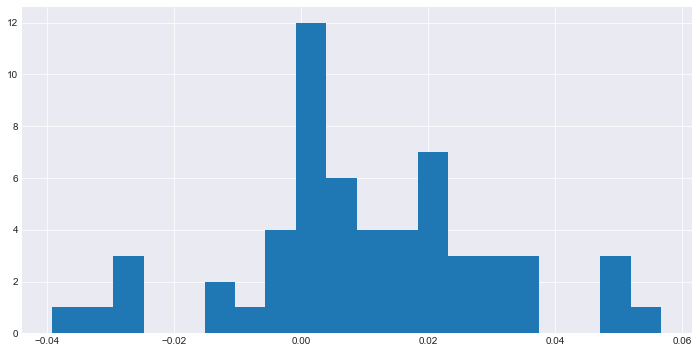

In [187]:
dfp_us_frac_new_increase.frac_increase_deaths.hist(bins=20)

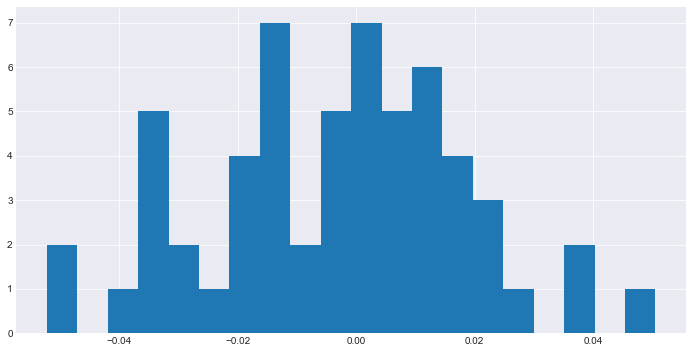

In [188]:
dfp_us_frac_new_increase.frac_increase_confirmed.hist(bins=20)

### Which states are increasing in new deaths <u>most</u> quickly?

In [189]:
dfp_us_frac_new_increase = (dfp_us_recent_1[['state', 'frac_increase_deaths', 'frac_increase_confirmed']].
                             drop_duplicates().
                             sort_values(by='frac_increase_deaths', ascending=0).
                             reset_index(drop=True)
                            )
dfp_us_frac_new_increase.head(10)

state  frac_increase_deaths  frac_increase_confirmed
0     California              0.056737                 0.050515
1        Arizona              0.050816                 0.013882
2       Delaware              0.050637                 0.004001
3       New York              0.048717                 0.011911
4       Virginia              0.036621                 0.020186
5      Tennessee              0.036396                 0.039671
6       Arkansas              0.034910                 0.009583
7   Rhode Island              0.030103                -0.017700
8  West Virginia              0.029545                 0.010586
9   Pennsylvania              0.028300                 0.005097

### Which states are increasing in new deaths <u>least</u> quickly?

In [190]:
dfp_us_frac_new_increase.tail(10)

state  frac_increase_deaths  frac_increase_confirmed
48       Montana             -0.004015                -0.027899
49      Illinois             -0.004150                -0.017363
50         Idaho             -0.007329                -0.011710
51       Georgia             -0.010528                 0.024974
52  North Dakota             -0.013632                -0.049757
53        Alaska             -0.025524                -0.035935
54  South Dakota             -0.026265                -0.032811
55       Wyoming             -0.026270                -0.032269
56        Hawaii             -0.033872                 0.023974
57      Nebraska             -0.039177                -0.032649

### Is there a day-of-the-week effect on new deaths?

Monday -> 0
Sunday -> 6

In [191]:
dfp_us_recent_1['dow'] = dfp_us_recent_1['date'].apply(lambda x: x.weekday())
dfp_us_dow = dfp_us_recent_1.dropna(subset={'deaths_new'}).copy()

In [192]:
deaths_new_col, death_pred_col = 'deaths_new', 'deaths_new_smooth_pred'
confirmed_new_col, confirmed_pred_col = 'confirmed_new', 'confirmed_new_smooth_pred'
dfp_us_dow['death_delta'] = dfp_us_dow[deaths_new_col]- dfp_us_dow[death_pred_col]
dfp_us_dow['death_rel_delta'] = (dfp_us_dow['death_delta']) / dfp_us_dow[death_pred_col]

dfp_us_dow['confirmed_delta'] = dfp_us_dow[confirmed_new_col]- dfp_us_dow[confirmed_pred_col]
dfp_us_dow['confirmed_rel_delta'] = dfp_us_dow['confirmed_delta'] / dfp_us_dow[confirmed_pred_col]
dfp_us_dow_deltas = (dfp_us_dow.groupby(['state', 'dow'], as_index=False).
                     agg({'death_delta': np.mean, 
                          'death_rel_delta': np.mean, # np.median
                          deaths_new_col: np.mean, 
                          death_pred_col: np.mean, 
                          'confirmed_delta': np.mean, 
                          'confirmed_rel_delta': np.mean}) # np.median
                    )

In [193]:
dfp_us_dow[dfp_us_dow.state=='Washington'].tail()

state       date country  confirmed  deaths  confirmed_lag1  \
1150  Washington 2020-12-19      US   222600.0  3104.0        220268.0   
1151  Washington 2020-12-20      US   222600.0  3104.0        222600.0   
1152  Washington 2020-12-21      US   226635.0  3106.0        222600.0   
1153  Washington 2020-12-22      US   227887.0  3131.0        226635.0   
1154  Washington 2020-12-23      US   230202.0  3162.0        227887.0   

      deaths_lag1  confirmed_new  deaths_new  mortality_rate  \
1150       3104.0         2332.0         0.0        0.013944   
1151       3104.0            0.0         0.0        0.013944   
1152       3104.0         4035.0         2.0        0.013705   
1153       3106.0         1252.0        25.0        0.013739   
1154       3131.0         2315.0        31.0        0.013736   

      deaths_new_smooth  confirmed_new_smooth  confirmed_new_smooth_log  \
1150          23.285714           1983.285714                  3.297385   
1151          23.285714           1684.428571                  3.226453   
1152          23.571429           2007.285714                  3.302609   
1153          27.142857           1946.000000                  3.289143   
1154          17.142857           2276.714286                  3.357309   

      deaths_new_smooth_log      unixtime  recovered  active         slope  \
1150               1.367090  1.608336e+09        NaN     NaN  1.373512e-08   
1151               1.367090  1.608422e+09        NaN     NaN  1.373512e-08   
1152               1.372386  1.608509e+09        NaN     NaN  1.373512e-08   
1153               1.433656  1.608595e+09        NaN     NaN  1.373512e-08   
1154               1.234083  1.608682e+09        NaN     NaN  1.373512e-08   

      confirmed_new_smooth_pred  frac_increase_confirmed  \
1150                       2244                -0.018846   
1151                       2202                -0.018846   
1152                       2160                -0.018846   
1153                       2120                -0.018846   
1154                       2080                -0.018846   

      deaths_new_smooth_pred  frac_increase_deaths  dow  death_delta  \
1150                      16              0.002736    5        -16.0   
1151                      16              0.002736    6        -16.0   
1152                      16              0.002736    0        -14.0   
1153                      16              0.002736    1          9.0   
1154                      16              0.002736    2         15.0   

      death_rel_delta  confirmed_delta  confirmed_rel_delta  
1150          -1.0000             88.0             0.039216  
1151          -1.0000          -2202.0            -1.000000  
1152          -0.8750           1875.0             0.868056  
1153           0.5625           -868.0            -0.409434  
1154           0.9375            235.0             0.112981

In [194]:
dfp_us_dow_deltas[dfp_us_dow_deltas.state == 'Washington']

state  dow  death_delta  death_rel_delta  deaths_new  \
378  Washington    0    -8.000000        -0.500000    8.000000   
379  Washington    1    -4.333333        -0.270833   11.666667   
380  Washington    2    30.333333         1.895833   46.333333   
381  Washington    3    18.666667         1.169444   34.333333   
382  Washington    4    -9.333333        -0.568056    6.333333   
383  Washington    5    -9.000000        -0.558333    6.666667   
384  Washington    6   -10.333333        -0.644444    5.333333   

     deaths_new_smooth_pred  confirmed_delta  confirmed_rel_delta  
378               16.000000       719.000000             0.311002  
379               16.000000      -430.333333            -0.200151  
380               16.000000      -619.666667            -0.261038  
381               15.666667        45.666667             0.042980  
382               15.666667       391.666667             0.181474  
383               15.666667      -408.000000            -0.138427  
384               15.666667       190.333333            -0.018712

In [195]:
# alpha_soft = 0.15
# alpha_hard = 0.8
# for state in ['Washington', 'California', 'New Jersey', 'Florida', 'Ohio']:
#     dfp_plot = dfp_us_dow_deltas[(dfp_us_dow_deltas.state == state)]  #(dfp_us_dow_deltas.deaths_new >= 10) & 
#     dfp_plot_raw = dfp_us_dow[dfp_us_dow.state == state]
    
#     p = plt.plot(dfp_plot['dow'], dfp_plot['death_rel_delta'], 'o', alpha=alpha_hard, label='deaths')
#     color = p[0].get_color()
#     plt.plot(dfp_plot_raw['dow'], dfp_plot_raw['death_rel_delta'], 'o', alpha=alpha_soft, label='raw deaths', color=color)
    
#     q = plt.plot(dfp_plot['dow'], dfp_plot['confirmed_rel_delta'], 'o', alpha=alpha_hard, label='confirmed')
#     color = q[0].get_color()
#     plt.plot(dfp_plot_raw['dow'], dfp_plot_raw['confirmed_rel_delta'], 'o', alpha=alpha_soft, label='raw confirmed', color=color)
    
#     plt.legend(loc='best')
#     plt.axhline(0, color='k')
#     plt.title(f'state={state}')

#     #plt.ylim([-0.5,0.5])
#     #plt.ylim([-2,2])
#     plt.show()

# Cases per capita by state

In [196]:
dfp_state_census = pd.read_csv('supporting_data/nst-est2019-alldata.csv')

In [197]:
dfp_us_g.shape

(14866, 12)

In [198]:
cols_state_pop = ['NAME', 'POPESTIMATE2019'] #'STATE',
dfp_state_census_clean = dfp_state_census[cols_state_pop][dfp_state_census['STATE'] > 0]
#dfp_state_census_clean = dfp_state_census_clean.rename(columns={'STATE': 'STATE_NUMBER'})
dfp_state_census_clean.columns = [x.lower() for x in dfp_state_census_clean.columns]
pop_col = 'population'
cols_state_translate = {'name': 'state', 'popestimate2019': pop_col}
dfp_state_census_clean = dfp_state_census_clean.rename(columns=cols_state_translate)
dfp_us_g1 = dfp_us_g.copy()
dfp_us_g1 = dfp_us_g1.merge(dfp_state_census_clean, on='state', how='inner')

# add normalized columns
norm_factor = 1E6
dfp_us_g1['deaths_new_per_1m'] = dfp_us_g1['deaths_new'] / dfp_us_g1[pop_col] * norm_factor
dfp_us_g1['confirmed_new_per_1m'] = dfp_us_g1['confirmed_new'] / dfp_us_g1[pop_col] * norm_factor
dfp_us_g1['deaths_new_per_1m_smooth'] = dfp_us_g1['deaths_new_smooth'] / dfp_us_g1[pop_col] * norm_factor
dfp_us_g1['confirmed_new_per_1m_smooth'] = dfp_us_g1['confirmed_new_smooth'] / dfp_us_g1[pop_col] * norm_factor

In [199]:
dfp_us_g1.shape

(13312, 17)

<a id='us_state_maps'></a>
# Plot maps

In [200]:
dfp_us_g1_newest = dfp_us_g1[dfp_us_g1.date == dfp_us_g1.date.max()].copy()
#print(f'There are {len(dfp_us_g1_newest.columns)}')
cols1 = set(dfp_us_g1_newest.columns)
dfp_us_g1_newest = dfp_us_g1_newest.merge(dfp_state_codes, left_on='state', right_on='state_name', how='left')
#print(f'After merge there are {len(dfp_us_g1_newest.columns)}')
cols2 = set(dfp_us_g1_newest.columns)

In [201]:
dfp_us_g1_newest = dfp_us_g1_newest.sort_values(by='confirmed_new_per_1m_smooth', ascending=0)
dfp_us_g1_newest.head(10)

date country         state  confirmed  deaths  confirmed_lag1  \
15 2020-12-23      US     Tennessee     541240    6380        534019.0   
31 2020-12-23      US    California    2002494   23558       1958508.0   
9  2020-12-23      US      Oklahoma     269276    2283        265620.0   
29 2020-12-23      US       Arizona     473273    8179        467215.0   
0  2020-12-23      US       Alabama     334569    4587        329811.0   
24 2020-12-23      US  Rhode Island      82066    1704         81187.0   
30 2020-12-23      US      Arkansas     207941    3376        205048.0   
42 2020-12-23      US       Indiana     476538    7645        471876.0   
17 2020-12-23      US          Utah     257697    1196        255085.0   
44 2020-12-23      US        Kansas     212852    2493        208066.0   

    deaths_lag1  confirmed_new  deaths_new  mortality_rate  deaths_new_smooth  \
15       6269.0         7221.0       111.0        0.011788         101.714286   
31      23239.0        43986.0       319.0        0.011764         248.714286   
9        2240.0         3656.0        43.0        0.008478          22.142857   
29       8125.0         6058.0        54.0        0.017282          92.714286   
0        4452.0         4758.0       135.0        0.013710          55.571429   
24       1678.0          879.0        26.0        0.020764          16.285714   
30       3338.0         2893.0        38.0        0.016235          43.142857   
42       7581.0         4662.0        64.0        0.016043          77.714286   
17       1173.0         2612.0        23.0        0.004641          14.285714   
44       2448.0         4786.0        45.0        0.011712          35.142857   

    confirmed_new_smooth  population  deaths_new_per_1m  confirmed_new_per_1m  \
15           8136.428571     6829174          16.253796           1057.375314   
31          41990.714286    39512223           8.073451           1113.225140   
9            3435.285714     3956971          10.866898            923.939043   
29           6293.428571     7278717           7.418890            832.289537   
0            4132.714286     4903185          27.533124            970.389655   
24            836.714286     1059361          24.543097            829.745479   
30           2348.142857     3017804          12.591938            958.644100   
42           5098.285714     6732219           9.506524            692.490841   
17           2426.000000     3205958           7.174143            814.733069   
44           2170.000000     2913314          15.446327           1642.802664   

    deaths_new_per_1m_smooth  confirmed_new_per_1m_smooth    state_name  \
15                 14.894083                  1191.422062     Tennessee   
31                  6.294616                  1062.727204    California   
9                   5.595911                   868.160448      Oklahoma   
29                 12.737724                   864.634327       Arizona   
0                  11.333741                   842.863218       Alabama   
24                 15.373149                   789.829233  Rhode Island   
30                 14.296110                   778.096542      Arkansas   
42                 11.543636                   757.296475       Indiana   
17                  4.455989                   756.716089          Utah   
44                 12.062846                   744.856202        Kansas   

   two_letter_code  
15              TN  
31              CA  
9               OK  
29              AZ  
0               AL  
24              RI  
30              AR  
42              IN  
17              UT  
44              KS

In [202]:
def plot_us_map(df, plot_col, color='Reds', col_state_abbrev='two_letter_code'):
    # this was adapted from example at https://plotly.com/python/choropleth-maps/
    import plotly.graph_objects as go
    fig = go.Figure(data=go.Choropleth(
        locations=df[col_state_abbrev], #df['code'], # Spatial coordinates
        z = df[plot_col].astype(float), # Data to be color-coded
        locationmode = 'USA-states', # set of locations match entries in `locations`
        colorscale = color,
        colorbar_title = plot_col,
    ))

    fig.update_layout(
        title_text = plot_col,
        geo_scope='usa', # limite map scope to USA
    )

    fig.show()
    return None

In [203]:
dfp_us_g1_newest.head()

date country       state  confirmed  deaths  confirmed_lag1  \
15 2020-12-23      US   Tennessee     541240    6380        534019.0   
31 2020-12-23      US  California    2002494   23558       1958508.0   
9  2020-12-23      US    Oklahoma     269276    2283        265620.0   
29 2020-12-23      US     Arizona     473273    8179        467215.0   
0  2020-12-23      US     Alabama     334569    4587        329811.0   

    deaths_lag1  confirmed_new  deaths_new  mortality_rate  deaths_new_smooth  \
15       6269.0         7221.0       111.0        0.011788         101.714286   
31      23239.0        43986.0       319.0        0.011764         248.714286   
9        2240.0         3656.0        43.0        0.008478          22.142857   
29       8125.0         6058.0        54.0        0.017282          92.714286   
0        4452.0         4758.0       135.0        0.013710          55.571429   

    confirmed_new_smooth  population  deaths_new_per_1m  confirmed_new_per_1m  \
15           8136.428571     6829174          16.253796           1057.375314   
31          41990.714286    39512223           8.073451           1113.225140   
9            3435.285714     3956971          10.866898            923.939043   
29           6293.428571     7278717           7.418890            832.289537   
0            4132.714286     4903185          27.533124            970.389655   

    deaths_new_per_1m_smooth  confirmed_new_per_1m_smooth  state_name  \
15                 14.894083                  1191.422062   Tennessee   
31                  6.294616                  1062.727204  California   
9                   5.595911                   868.160448    Oklahoma   
29                 12.737724                   864.634327     Arizona   
0                  11.333741                   842.863218     Alabama   

   two_letter_code  
15              TN  
31              CA  
9               OK  
29              AZ  
0               AL

In [204]:
dfp_us_g1_newest[dfp_us_g1_newest.state == 'Washington']

date country       state  confirmed  deaths  confirmed_lag1  \
20 2020-12-23      US  Washington     230202    3162        227887.0   

    deaths_lag1  confirmed_new  deaths_new  mortality_rate  deaths_new_smooth  \
20       3131.0         2315.0        31.0        0.013736          17.142857   

    confirmed_new_smooth  population  deaths_new_per_1m  confirmed_new_per_1m  \
20           2276.714286     7614893            4.07097            304.009524   

    deaths_new_per_1m_smooth  confirmed_new_per_1m_smooth  state_name  \
20                  2.251228                   298.981783  Washington   

   two_letter_code  
20              WA

In [205]:
plot_us_map(dfp_us_g1_newest, plot_col='confirmed_new_per_1m_smooth')

In [206]:
plot_us_map(dfp_us_g1_newest, plot_col='deaths_new_per_1m_smooth')

In [207]:
dfp_us_g1_newest = dfp_us_g1_newest.merge(dfp_us_frac_new_increase, on='state', how='left')

In [208]:
plot_us_map(dfp_us_g1_newest, plot_col='frac_increase_confirmed')

In [209]:
plot_us_map(dfp_us_g1_newest, plot_col='frac_increase_deaths')

# County level

In [210]:
os.getcwd()

'/Users/tboats/Dropbox (Facebook)/personal/data_sciencey/covid_19/analysis'

In [211]:
dfp_king_raw = pd.read_csv('../COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/03-22-2020.csv')

In [212]:
dfp_king_raw.head()

FIPS         Admin2 Province_State Country_Region    Last_Update  \
0  36061.0  New York City       New York             US  3/22/20 23:45   
1  36059.0         Nassau       New York             US  3/22/20 23:45   
2  36119.0    Westchester       New York             US  3/22/20 23:45   
3  36103.0        Suffolk       New York             US  3/22/20 23:45   
4  36087.0       Rockland       New York             US  3/22/20 23:45   

         Lat      Long_  Confirmed  Deaths  Recovered  Active  \
0  40.767273 -73.971526       9654      63          0       0   
1  40.740665 -73.589419       1900       4          0       0   
2  41.162784 -73.757417       1873       0          0       0   
3  40.883201 -72.801217       1034       9          0       0   
4  41.150279 -74.025605        455       1          0       0   

                  Combined_Key  
0  New York City, New York, US  
1         Nassau, New York, US  
2    Westchester, New York, US  
3        Suffolk, New York, US  
4       Rockland, New York, US

In [213]:
dfp_king_raw.shape

(3419, 12)

In [214]:
dfp_king_raw[(dfp_king_raw.Country_Region == 'US') & (dfp_king_raw.Admin2 == 'King')]

FIPS Admin2 Province_State Country_Region    Last_Update        Lat  \
45    53033.0   King     Washington             US  3/22/20 23:45  47.491379   
2843  48269.0   King          Texas             US  3/22/20 23:45  33.616438   

           Long_  Confirmed  Deaths  Recovered  Active          Combined_Key  
45   -121.834613       1040      75          0       0  King, Washington, US  
2843 -100.255806          0       0          0       0       King, Texas, US

In [215]:
dfp_king_raw.columns

Index(['FIPS', 'Admin2', 'Province_State', 'Country_Region', 'Last_Update',
       'Lat', 'Long_', 'Confirmed', 'Deaths', 'Recovered', 'Active',
       'Combined_Key'],
      dtype='object')

In [216]:
dfp_king_raw.Country_Region.value_counts()

US              3178
China             33
Canada            14
Australia         10
France            10
                ... 
Lebanon            1
Algeria            1
Cyprus             1
Saudi Arabia       1
Hungary            1
Name: Country_Region, Length: 168, dtype: int64

In [217]:
datetime.datetime.strptime('01-27-2020', '%m-%d-%Y')

datetime.datetime(2020, 1, 27, 0, 0)

In [218]:
len(data_paths)

256

In [219]:
def clean_county(
    state_base_dir='../COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/',
    grouping_cols=['country', 'state', 'county']
):
    # load and clean data from CSSEGIS
    
    data_paths_raw = os.listdir(state_base_dir)
    data_paths = sorted([path for path in data_paths_raw if path.endswith('csv')])
    list_dfp_states = []
    cols_of_interest = ['country', 'state_raw', 'county', 'date', 'confirmed', 'deaths', 'recovered']
    for idx, path in enumerate(data_paths):
        if (idx + 1) % 10 == 0:
            print(f'{idx + 1} of {len(data_paths)} ({100 * (idx + 1) / len(data_paths)}%)')
        
        # check if date is 2020-03-22 or later (schema change)
        file_date = path.split('.')[0]
        file_dt = datetime.datetime.strptime(file_date, '%m-%d-%Y')
        if file_dt < datetime.datetime(2020,3,22):
            continue
        
        full_path = os.path.join(state_base_dir, path)

        # read state data
        dfp_temp = pd.read_csv(full_path)
        cols = list(dfp_temp.columns)
        #print(dfp_temp.columns)

        # clean column names
        cols_translate = {'Country/Region': 'country',
                          'Province/State': 'state_raw',
                          'Confirmed': 'confirmed',
                          'Deaths': 'deaths',
                          'Recovered': 'recovered',
                          'Country_Region': 'country',
                          'Province_State': 'state_raw',
                          'Admin2': 'county',
                          'Last_Update': 'Last Update',
                          'People_Hospitalized': 'people_hospitalized'
                         }
        dfp_temp = dfp_temp.rename(columns=cols_translate)
        
        #dfp_temp['date'] = dfp_temp['Last Update'].apply(lambda x: parser.parse(x).date())

        dfp_temp['date'] = file_dt  #datetime.datetime.strptime(path.split('.')[0], '%m-%d-%Y')
        #dfp_temp['date'] = dfp_temp['date'].apply(lambda x: datetime.datetime(x.year, x.month, x.day))
        dfp_temp = dfp_temp[dfp_temp['country'] == 'US']
        list_dfp_states.append(dfp_temp[cols_of_interest])
    dfp_us_raw = pd.concat(list_dfp_states)
    dfp_us_raw['state_clean_1'] = dfp_us_raw['state_raw'].apply(lambda x: re.findall('\, ([A-Z]{2}$)', x)[0].strip() if re.findall('\, ([A-Z]{2}$)', x) else x)

    # load codes to convert two-letter codes to state names
    dfp_state_codes = pd.read_csv('supporting_data/us_state_to_two_letter_code.csv')
    dfp_state_codes = dfp_state_codes.rename(columns={'state': 'state_name'})
    dfp_us = dfp_us_raw.merge(dfp_state_codes, left_on=['state_clean_1'], right_on=['two_letter_code'], how='left')

    # get the most appropriate state name
    dfp_us['abbrev'] = ~dfp_us['state_name'].isnull()
    dfp_us['state_clean'] = dfp_us.apply(lambda x: x['state_name'] if x['abbrev'] else x['state_clean_1'], axis=1)
    dfp_us = dfp_us.rename(columns={'state_clean': 'state'})

    # aggregate infections by state
    dfp_us_g = (dfp_us.groupby(['date'] + grouping_cols, as_index=False).
                agg({
                    'confirmed': np.sum,
                    'deaths': np.sum,
                    #'recovered': np.sum,
                   })
               )
    dfp_us_g = dfp_us_g.sort_values(by='date')
    #dfp_us_g = dfp_us_g.rename(columns={'state_clean': 'state'})
    #dfp_us_g['active'] = dfp_us_g['confirmed'] - dfp_us_g['recovered']
    dfp_us_g['confirmed_lag1'] = dfp_us_g.groupby(grouping_cols)['confirmed'].shift(1)
    dfp_us_g['deaths_lag1'] = dfp_us_g.groupby(grouping_cols)['deaths'].shift(1)
    dfp_us_g['confirmed_new'] = dfp_us_g['confirmed'] - dfp_us_g['confirmed_lag1']
    dfp_us_g['deaths_new'] = dfp_us_g['deaths'] - dfp_us_g['deaths_lag1']
    dfp_us_g['deaths_new'] = dfp_us_g['deaths_new'].fillna(0)
    dfp_us_g['mortality_rate'] = dfp_us_g['deaths'] / dfp_us_g['confirmed']
    
    # smoothed trend
    dfp_us_g['deaths_new_smooth'] = dfp_us_g.groupby(grouping_cols, as_index=False)['deaths_new'].rolling(7).mean().reset_index(0,drop=True)
    dfp_us_g['confirmed_new_smooth'] = dfp_us_g.groupby(grouping_cols, as_index=False)['confirmed_new'].rolling(7).mean().reset_index(0,drop=True)
    return dfp_us_g

In [220]:
dfp_county_g = clean_county()

10 of 337 (2.9673590504451037%)
20 of 337 (5.9347181008902075%)
30 of 337 (8.90207715133531%)
40 of 337 (11.869436201780415%)
50 of 337 (14.836795252225519%)
60 of 337 (17.80415430267062%)
70 of 337 (20.771513353115726%)
80 of 337 (23.73887240356083%)
90 of 337 (26.706231454005934%)
100 of 337 (29.673590504451038%)
110 of 337 (32.640949554896146%)
120 of 337 (35.60830860534124%)
130 of 337 (38.57566765578635%)
140 of 337 (41.54302670623145%)
150 of 337 (44.510385756676556%)
160 of 337 (47.47774480712166%)
170 of 337 (50.445103857566764%)
180 of 337 (53.41246290801187%)
190 of 337 (56.37982195845697%)
200 of 337 (59.347181008902076%)
210 of 337 (62.31454005934718%)
220 of 337 (65.28189910979229%)
230 of 337 (68.24925816023739%)
240 of 337 (71.21661721068249%)
250 of 337 (74.1839762611276%)
260 of 337 (77.1513353115727%)
270 of 337 (80.1186943620178%)
280 of 337 (83.0860534124629%)
290 of 337 (86.05341246290801%)
300 of 337 (89.02077151335311%)
310 of 337 (91.98813056379822%)
320 of 337 

In [221]:
def plot_county(state, county):
    dfp_county_oi = dfp_county_g[(dfp_county_g.state == state) & (dfp_county_g.county == county)]
    plot_smoothed_trend(dfp_county_oi, [county], cols_plot=['confirmed_new', 'deaths_new'], state_col='county')
    return dfp_county_oi

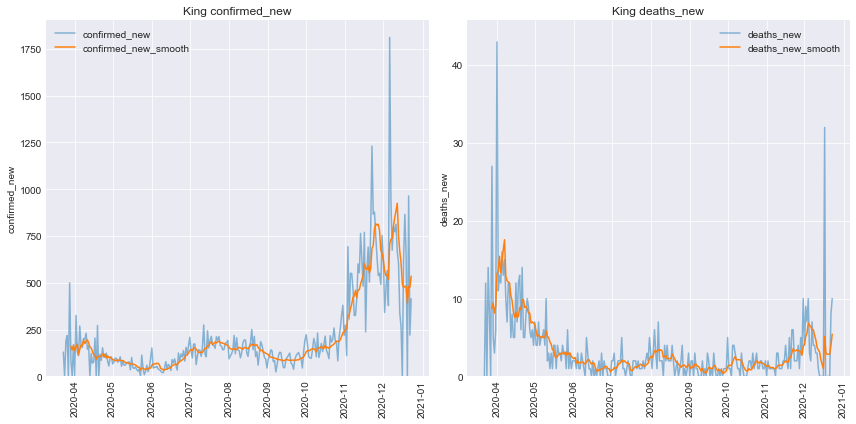

In [222]:
dfp_king = plot_county('Washington', 'King')

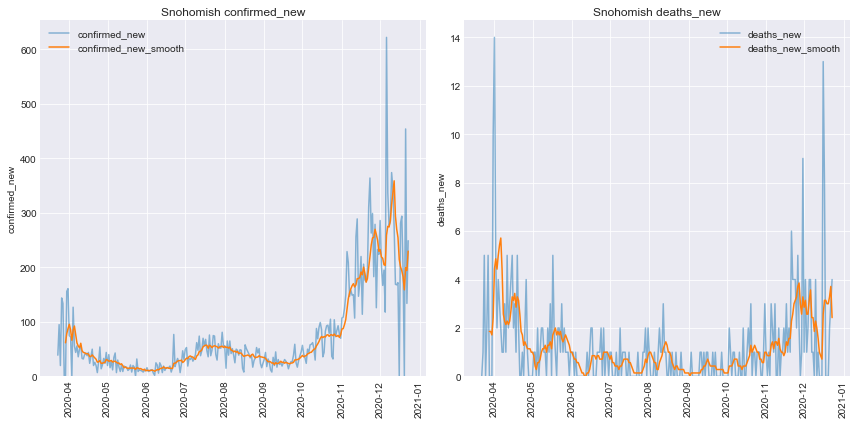

In [223]:
dfp_sno = plot_county('Washington', 'Snohomish')

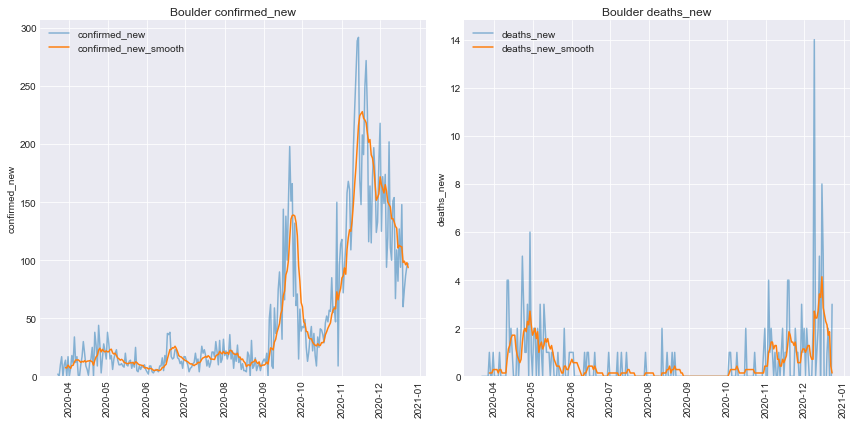

In [224]:
_ = plot_county('Colorado', 'Boulder')

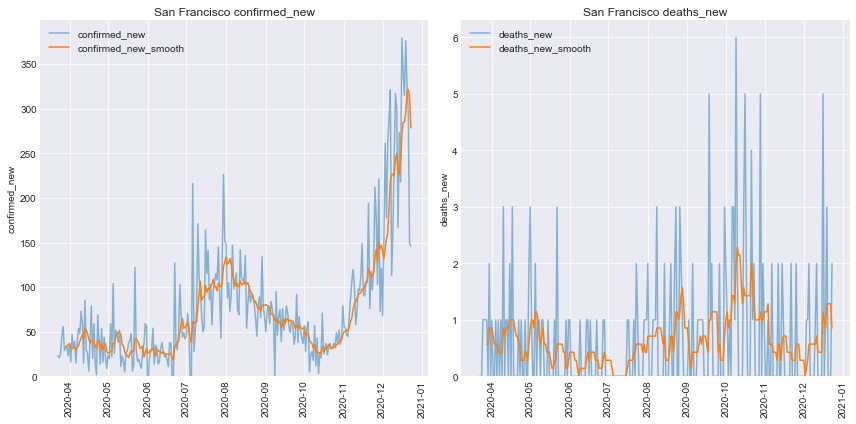

In [225]:
_ = plot_county('California', 'San Francisco')

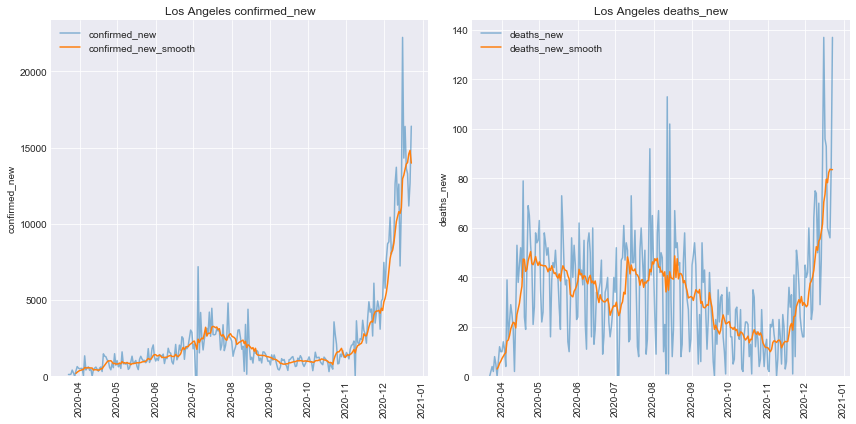

In [226]:
_ = plot_county('California', 'Los Angeles')